
Celem projektu jest analiza danych dotyczących udaru mózgu, znajdujących się w pliku `healthcare-dataset-stroke-data.csv`. Wyniki należy przedstawić w formie  raportu (RMarkdown, Jupyter, etc.) zawierającego kod programu jak i opisy dokonywanych decyzji. Analiza powinna zawierać co najmniej następujące punkty:

1. Czyszczenie danych (usuwanie/inputacja braków danych, naprawa błędów, transformacje danych, rozwiązanie problemu wartości odstających)
2. Eksploracyjna analiza danych
3. Zamodelowanie zmiennej `stroke` na podstawie pozostałych zmiennych. Minimum 3 modele.
4. Ewaluacja na zbiorze testowym (wybór modelu i metryk z uzasadnieniem)

Możliwe jest rozwiązaniem w języku R lub Python. Rozwiązania wysłać do 24.01.2022 na adres mailowy: michalmaj116@gmail.com z tytułem "studia podyplomowe"


# 1. Importy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
#from sklearn.impute import SimpleImputer
#from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_curve, auc

from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier 
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.svm import SVC



# 2. Wczytanie danych

In [2]:
data_student = pd.read_csv("data/mat2.csv", comment="#", sep=',')
data_student.head()

Unnamed: 0 school sex  age address famsize Pstatus  Medu  Fedu     Mjob  \
0           0     GP   F   18       U     GT3       A     4     4  at_home   
1           1     GP   F   17       U     GT3       T     1     1  at_home   
2           2     GP   F   15       U     LE3       T     1     1  at_home   
3           3     GP   F   15       U     GT3       T     4     2   health   
4           4     GP   F   16       U     GT3       T     3     3    other   

   ... famrel freetime goout  Dalc  Walc  health absences  G1  G2  G3  
0  ...      4        3     4     1     1       3        6   5   6   6  
1  ...      5        3     3     1     1       3        4   5   5   6  
2  ...      4        3     2     2     3       3       10   7   8  10  
3  ...      3        2     2     1     1       5        2  15  14  15  
4  ...      4        3     2     1     2       5        4   6  10  10  

[5 rows x 34 columns]

# 3. Zrozumienie danych
### Zbiór danych
https://www.kaggle.com/datasets/henryshan/student-performance-prediction

Dane te dotyczą osiągnięć uczniów w szkołach średnich w dwóch portugalskich szkołach . Atrybuty danych obejmują oceny uczniów, cechy demograficzne, społeczne i związane ze szkołą. Zebrano je przy użyciu raportów szkolnych i kwestionariuszy.

Udostępniono dwa zbiory danych dotyczące wyników z dwóch odrębnych przedmiotów: matematyki (mat.csv) i języka portugalskiego (por.csv) . W [Cortez i Silva, 2008] oba zbiory danych modelowano w ramach zadań klasyfikacji i regresji binarnej/pięciopoziomowej.

Przeanalizuję dane dotyczące matematyki.

Skala ocen:

0-9 - niedostatecznie
10-17 - dost, db
18-19, 20 - bdb, cel


- **School**: szkoła ucznia (binarnie: „GP” – Gabriel Pereira lub „MS” – Mousinho da Silveira)

- **Sex** : płeć ucznia (binarnie: „F” – kobieta lub „M” – mężczyzna

- **Age** : wiek ucznia (numeryczny: od 15 do 22 lat)

- **address**: typ adresu domowego ucznia (binarnie: „U” – miejski lub „R” – wiejski)

- **famsize**: wielkość rodziny (binarnie: „LE3” – mniejsza lub równa 3 lub „GT3” – większa niż 3)

- **Pstatus**: status konkubinacyjny rodziców (binarnie: „T” – mieszkający razem lub „A” – osobno)

- **Medu**: wykształcenie matki (liczba: 0 – brak, 1 – wykształcenie podstawowe (IV klasa), 2 – V–IX klasa, 3 – wykształcenie średnie lub 4 – wykształcenie wyższe)

- **Fedu**: wykształcenie ojca (liczba: 0 – brak, 1 – wykształcenie podstawowe (IV klasa), 2 – V–IX klasa, 3 – wykształcenie średnie lub 4 – wykształcenie wyższe)

- **Mjob**: zawód matki (nominalny: „nauczyciel”, „związany ze służbą zdrowia”, „służby cywilne” (np. administracja lub policja), „w_domu” lub „inny”)

- **Fjob**: zawód ojca (nominalny: „nauczyciel”, „służba zdrowia”, „służba” cywilna (np. administracja lub policja), „w_domu” lub „inny”)

- **reason**: powód, aby wybrać tę szkołę (nominalny: blisko „domu”, „reputacja szkoły”, „preferowany kurs” lub „inny”)

- **guardian**: opiekun ucznia (nominalny: „matka”, „ojciec” lub „inny”)

- **traveltime**: czas dojazdu z domu do szkoły (liczbowo: 1–<15 min., 2–15 do 30 min., 3–30 min. do 1 godziny lub 4–>1 godzina)

- **studytime**: tygodniowy czas nauki (liczbowo: 1–<2 godziny, 2–2 do 5 godzin, 3–5 do 10 godzin lub 4–>10 godzin)

- **failures**: liczba przeszłych niepowodzeń klas (liczbowa: n jeśli 1<=n<3, w przeciwnym razie 4)

- **schoolsup**: dodatkowe wsparcie edukacyjne (binarne: tak lub nie)

- **famsup**: rodzinne wsparcie edukacyjne (binarne: tak lub nie)

- **paid**: dodatkowe płatne zajęcia w ramach przedmiotu kursu (matematyka lub portugalski) (binarnie: tak lub nie)

- **activities**: zajęcia pozalekcyjne (binarne: tak lub nie)

- **nursery**: uczęszczał do przedszkola (binarnie: tak lub nie)

- **higher**: chce podjąć studia wyższe (binarnie: tak lub nie)

- **internet**:Dostęp do Internetu w domu (binarnie: tak lub nie)

- **romantic**:w związku romantycznym (binarnie: tak lub nie)

- **famrel**: jakość relacji rodzinnych (liczbowo: od 1 – bardzo zła do 5 – doskonała)

- **freetime**: czas wolny po szkole (liczbowo: od 1 – bardzo niska do 5 – bardzo wysoka)

- **goout**: wyjście z przyjaciółmi (liczba: od 1 - bardzo niska do 5 - bardzo wysoka)

- **Dalc**: spożycie alkoholu w ciągu dnia roboczego (liczbowe: od 1 – bardzo niskie do 5 – bardzo wysokie)

- **Walc**: weekendowe spożycie alkoholu (liczbowe: od 1 – bardzo niskie do 5 – bardzo wysokie)

- **health**: aktualny stan zdrowia (numeryczny: od 1 – bardzo zły do 5 – bardzo dobry)

- **absence**: liczba nieobecności w szkole (numeryczna: od 0 do 93)

- **G1**: ocena z pierwszego okresu (numeryczna: od 0 do 20)

- **G2**: ocena z drugiego okresu (numeryczna: od 0 do 20)

- **G3**: ocena końcowa (numeryczna: od 0 do 20, cel wyjściowy)




In [3]:
# sprawdzam brakujące dane, i kategorie danych
type(data_student)
data_student.shape
data_student.columns
data_student.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 34 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  395 non-null    int64 
 1   school      395 non-null    object
 2   sex         395 non-null    object
 3   age         395 non-null    int64 
 4   address     395 non-null    object
 5   famsize     395 non-null    object
 6   Pstatus     395 non-null    object
 7   Medu        395 non-null    int64 
 8   Fedu        395 non-null    int64 
 9   Mjob        395 non-null    object
 10  Fjob        395 non-null    object
 11  reason      395 non-null    object
 12  guardian    395 non-null    object
 13  traveltime  395 non-null    int64 
 14  studytime   395 non-null    int64 
 15  failures    395 non-null    int64 
 16  schoolsup   395 non-null    object
 17  famsup      395 non-null    object
 18  paid        395 non-null    object
 19  activities  395 non-null    object
 20  nursery   

In [4]:
#pozmieniam zmienne objekt na category - jednak nie będę zmieniać
#data_student.school = data_student.school.astype('category')
#data_student.sex = data_student.sex.astype('category')
#data_student.address = data_student.address.astype('category')
#data_student.famsize = data_student.famsize.astype('category')
#data_student.Pstatus = data_student.Pstatus.astype('category')
#data_student.Mjob = data_student.Mjob.astype('category')
#data_student.Fjob = data_student.Fjob.astype('category')
#data_student.reason = data_student.reason.astype('category')
#data_student.guardian = data_student.guardian.astype('category')
#data_student.schoolsup = data_student.schoolsup.astype('category')
#data_student.famsup = data_student.famsup.astype('category')
#data_student.paid = data_student.paid.astype('category')
#data_student.activities = data_student.activities.astype('category')
#data_student.nursery = data_student.nursery.astype('category')
#data_student.romantic = data_student.romantic.astype('category')

In [5]:
num_cols = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout',
            'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
cat_cols = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 
            'famsup', 'paid', 'activities', 'nursery', 'romantic']

### Przygotowanie danych

In [6]:
#usunięcie kolumny unnamed0 - nic nie wnosi
data_student.drop('Unnamed: 0', axis=1, inplace=True)
data_student.head()

school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        6   5   6   6  
1      5        3      3     1     1      3        4   5   5   6  
2      4        3      2     2     3      3       10   7   8  10  
3      3        2      2     1     1      5        2  15  14  15  
4      4        3      2     1     2      5        4   6  10  10  

[5 rows x 33 columns]

In [7]:
#KODOWANIE ZMIENNYCH KATEGORYCZNYCH
encoder = OneHotEncoder()
transformed_data = encoder.fit_transform(data_student[cat_cols])
print(transformed_data.toarray())

[[1. 0. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 [1. 0. 1. ... 1. 1. 0.]
 ...
 [0. 1. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 1. 1. 0.]]


In [8]:
#NORMALIZACJA ZMIENNYCH
scaler = MinMaxScaler()

# Dopasowanie skalera do danych i wykonanie transformacji
data_student_normalized = scaler.fit_transform(data_student[num_cols])
print(data_student_normalized)

[[0.42857143 1.         1.         ... 0.125      0.31578947 0.3       ]
 [0.28571429 0.25       0.25       ... 0.125      0.26315789 0.3       ]
 [0.         0.25       0.25       ... 0.25       0.42105263 0.5       ]
 ...
 [0.85714286 0.25       0.25       ... 0.4375     0.42105263 0.35      ]
 [0.42857143 0.75       0.5        ... 0.5        0.63157895 0.5       ]
 [0.57142857 0.25       0.25       ... 0.3125     0.47368421 0.45      ]]


In [9]:
#poznaje kolejne kolumny nietypowe
data_student.groupby('school').count()
#nierówność duża między dwiema rodzajami szkół

sex  age  address  famsize  Pstatus  Medu  Fedu  Mjob  Fjob  reason  \
school                                                                        
GP      349  349      349      349      349   349   349   349   349     349   
MS       46   46       46       46       46    46    46    46    46      46   

        ...  famrel  freetime  goout  Dalc  Walc  health  absences   G1   G2  \
school  ...                                                                    
GP      ...     349       349    349   349   349     349       349  349  349   
MS      ...      46        46     46    46    46      46        46   46   46   

         G3  
school       
GP      349  
MS       46  

[2 rows x 32 columns]

In [10]:
data_student.groupby('sex').count()

school  age  address  famsize  Pstatus  Medu  Fedu  Mjob  Fjob  reason  \
sex                                                                           
F       208  208      208      208      208   208   208   208   208     208   
M       187  187      187      187      187   187   187   187   187     187   

     ...  famrel  freetime  goout  Dalc  Walc  health  absences   G1   G2   G3  
sex  ...                                                                        
F    ...     208       208    208   208   208     208       208  208  208  208  
M    ...     187       187    187   187   187     187       187  187  187  187  

[2 rows x 32 columns]

In [11]:
data_student.groupby('address').count()
#głównie miejskie

school  sex  age  famsize  Pstatus  Medu  Fedu  Mjob  Fjob  reason  \
address                                                                       
R            88   88   88       88       88    88    88    88    88      88   
U           307  307  307      307      307   307   307   307   307     307   

         ...  famrel  freetime  goout  Dalc  Walc  health  absences   G1   G2  \
address  ...                                                                    
R        ...      88        88     88    88    88      88        88   88   88   
U        ...     307       307    307   307   307     307       307  307  307   

          G3  
address       
R         88  
U        307  

[2 rows x 32 columns]

In [12]:
data_student.groupby('famsize').count()

school  sex  age  address  Pstatus  Medu  Fedu  Mjob  Fjob  reason  \
famsize                                                                       
GT3         281  281  281      281      281   281   281   281   281     281   
LE3         114  114  114      114      114   114   114   114   114     114   

         ...  famrel  freetime  goout  Dalc  Walc  health  absences   G1   G2  \
famsize  ...                                                                    
GT3      ...     281       281    281   281   281     281       281  281  281   
LE3      ...     114       114    114   114   114     114       114  114  114   

          G3  
famsize       
GT3      281  
LE3      114  

[2 rows x 32 columns]

In [13]:
data_student.groupby('Pstatus').count()
#A - rodzice mieszkający osobno

school  sex  age  address  famsize  Medu  Fedu  Mjob  Fjob  reason  \
Pstatus                                                                       
A            41   41   41       41       41    41    41    41    41      41   
T           354  354  354      354      354   354   354   354   354     354   

         ...  famrel  freetime  goout  Dalc  Walc  health  absences   G1   G2  \
Pstatus  ...                                                                    
A        ...      41        41     41    41    41      41        41   41   41   
T        ...     354       354    354   354   354     354       354  354  354   

          G3  
Pstatus       
A         41  
T        354  

[2 rows x 32 columns]

In [14]:
data_student.groupby('Mjob').count()

school  sex  age  address  famsize  Pstatus  Medu  Fedu  Fjob  \
Mjob                                                                      
at_home       59   59   59       59       59       59    59    59    59   
health        34   34   34       34       34       34    34    34    34   
other        141  141  141      141      141      141   141   141   141   
services     103  103  103      103      103      103   103   103   103   
teacher       58   58   58       58       58       58    58    58    58   

          reason  ...  famrel  freetime  goout  Dalc  Walc  health  absences  \
Mjob              ...                                                          
at_home       59  ...      59        59     59    59    59      59        59   
health        34  ...      34        34     34    34    34      34        34   
other        141  ...     141       141    141   141   141     141       141   
services     103  ...     103       103    103   103   103     103       103   
teacher       58  ...      58        58     58    58    58      58        58   

           G1   G2   G3  
Mjob                     
at_home    59   59   59  
health     34   34   34  
other     141  141  141  
services  103  103  103  
teacher    58   58   58  

[5 rows x 32 columns]

In [15]:
data_student.groupby('Fjob').count()

school  sex  age  address  famsize  Pstatus  Medu  Fedu  Mjob  \
Fjob                                                                      
at_home       20   20   20       20       20       20    20    20    20   
health        18   18   18       18       18       18    18    18    18   
other        217  217  217      217      217      217   217   217   217   
services     111  111  111      111      111      111   111   111   111   
teacher       29   29   29       29       29       29    29    29    29   

          reason  ...  famrel  freetime  goout  Dalc  Walc  health  absences  \
Fjob              ...                                                          
at_home       20  ...      20        20     20    20    20      20        20   
health        18  ...      18        18     18    18    18      18        18   
other        217  ...     217       217    217   217   217     217       217   
services     111  ...     111       111    111   111   111     111       111   
teacher       29  ...      29        29     29    29    29      29        29   

           G1   G2   G3  
Fjob                     
at_home    20   20   20  
health     18   18   18  
other     217  217  217  
services  111  111  111  
teacher    29   29   29  

[5 rows x 32 columns]

In [16]:
data_student.groupby('reason').count()

school  sex  age  address  famsize  Pstatus  Medu  Fedu  Mjob  \
reason                                                                      
course         145  145  145      145      145      145   145   145   145   
home           109  109  109      109      109      109   109   109   109   
other           36   36   36       36       36       36    36    36    36   
reputation     105  105  105      105      105      105   105   105   105   

            Fjob  ...  famrel  freetime  goout  Dalc  Walc  health  absences  \
reason            ...                                                          
course       145  ...     145       145    145   145   145     145       145   
home         109  ...     109       109    109   109   109     109       109   
other         36  ...      36        36     36    36    36      36        36   
reputation   105  ...     105       105    105   105   105     105       105   

             G1   G2   G3  
reason                     
course      145  145  145  
home        109  109  109  
other        36   36   36  
reputation  105  105  105  

[4 rows x 32 columns]

In [17]:
data_student.groupby('guardian').count()
#opiekun ucznia

school  sex  age  address  famsize  Pstatus  Medu  Fedu  Mjob  Fjob  \
guardian                                                                        
father        90   90   90       90       90       90    90    90    90    90   
mother       273  273  273      273      273      273   273   273   273   273   
other         32   32   32       32       32       32    32    32    32    32   

          ...  famrel  freetime  goout  Dalc  Walc  health  absences   G1  \
guardian  ...                                                               
father    ...      90        90     90    90    90      90        90   90   
mother    ...     273       273    273   273   273     273       273  273   
other     ...      32        32     32    32    32      32        32   32   

           G2   G3  
guardian            
father     90   90  
mother    273  273  
other      32   32  

[3 rows x 32 columns]

In [18]:
data_student.groupby('schoolsup').count()
#dodatkowe wsparcie edukacyjne

school  sex  age  address  famsize  Pstatus  Medu  Fedu  Mjob  \
schoolsup                                                                  
no            344  344  344      344      344      344   344   344   344   
yes            51   51   51       51       51       51    51    51    51   

           Fjob  ...  famrel  freetime  goout  Dalc  Walc  health  absences  \
schoolsup        ...                                                          
no          344  ...     344       344    344   344   344     344       344   
yes          51  ...      51        51     51    51    51      51        51   

            G1   G2   G3  
schoolsup                 
no         344  344  344  
yes         51   51   51  

[2 rows x 32 columns]

In [19]:
data_student.groupby('famsup').count()
#dodatkowe wsparcie edukacyjne - w rodzinie

school  sex  age  address  famsize  Pstatus  Medu  Fedu  Mjob  Fjob  \
famsup                                                                        
no         153  153  153      153      153      153   153   153   153   153   
yes        242  242  242      242      242      242   242   242   242   242   

        ...  famrel  freetime  goout  Dalc  Walc  health  absences   G1   G2  \
famsup  ...                                                                    
no      ...     153       153    153   153   153     153       153  153  153   
yes     ...     242       242    242   242   242     242       242  242  242   

         G3  
famsup       
no      153  
yes     242  

[2 rows x 32 columns]

In [20]:
data_student.groupby('paid').count()
#dodatkowe wsparcie edukacyjne - płatne zajęcia

school  sex  age  address  famsize  Pstatus  Medu  Fedu  Mjob  Fjob  \
paid                                                                        
no       214  214  214      214      214      214   214   214   214   214   
yes      181  181  181      181      181      181   181   181   181   181   

      ...  famrel  freetime  goout  Dalc  Walc  health  absences   G1   G2  \
paid  ...                                                                    
no    ...     214       214    214   214   214     214       214  214  214   
yes   ...     181       181    181   181   181     181       181  181  181   

       G3  
paid       
no    214  
yes   181  

[2 rows x 32 columns]

In [21]:
data_student.groupby('activities').count()
# zajęcia pozalekcyjne

school  sex  age  address  famsize  Pstatus  Medu  Fedu  Mjob  \
activities                                                                  
no             194  194  194      194      194      194   194   194   194   
yes            201  201  201      201      201      201   201   201   201   

            Fjob  ...  famrel  freetime  goout  Dalc  Walc  health  absences  \
activities        ...                                                          
no           194  ...     194       194    194   194   194     194       194   
yes          201  ...     201       201    201   201   201     201       201   

             G1   G2   G3  
activities                 
no          194  194  194  
yes         201  201  201  

[2 rows x 32 columns]

In [22]:
data_student.groupby('nursery').count()
#przedszkole

school  sex  age  address  famsize  Pstatus  Medu  Fedu  Mjob  Fjob  \
nursery                                                                        
no           81   81   81       81       81       81    81    81    81    81   
yes         314  314  314      314      314      314   314   314   314   314   

         ...  famrel  freetime  goout  Dalc  Walc  health  absences   G1   G2  \
nursery  ...                                                                    
no       ...      81        81     81    81    81      81        81   81   81   
yes      ...     314       314    314   314   314     314       314  314  314   

          G3  
nursery       
no        81  
yes      314  

[2 rows x 32 columns]

In [23]:
data_student.groupby('romantic').count()
#zwiazek

school  sex  age  address  famsize  Pstatus  Medu  Fedu  Mjob  Fjob  \
romantic                                                                        
no           263  263  263      263      263      263   263   263   263   263   
yes          132  132  132      132      132      132   132   132   132   132   

          ...  famrel  freetime  goout  Dalc  Walc  health  absences   G1  \
romantic  ...                                                               
no        ...     263       263    263   263   263     263       263  263   
yes       ...     132       132    132   132   132     132       132  132   

           G2   G3  
romantic            
no        263  263  
yes       132  132  

[2 rows x 32 columns]

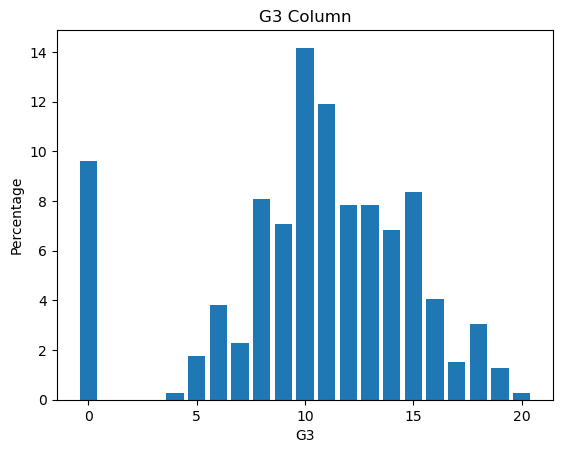

In [24]:
#sprawdzam wartości zmiennej celu - chyba bym pogrupowała w jakieś wartości ocen????

counts = data_student['G3'].value_counts()
percentages = counts / counts.sum() * 100

plt.bar(percentages.index, percentages.values) 
plt.title('G3 Column')
plt.xlabel('G3')
plt.ylabel('Percentage')
plt.show()


In [25]:
#badam zmienne numeryczne
data_student.describe()

age        Medu        Fedu  traveltime   studytime    failures  \
count  395.000000  395.000000  395.000000  395.000000  395.000000  395.000000   
mean    16.696203    2.749367    2.521519    1.448101    2.035443    0.334177   
std      1.276043    1.094735    1.088201    0.697505    0.839240    0.743651   
min     15.000000    0.000000    0.000000    1.000000    1.000000    0.000000   
25%     16.000000    2.000000    2.000000    1.000000    1.000000    0.000000   
50%     17.000000    3.000000    2.000000    1.000000    2.000000    0.000000   
75%     18.000000    4.000000    3.000000    2.000000    2.000000    0.000000   
max     22.000000    4.000000    4.000000    4.000000    4.000000    3.000000   

           famrel    freetime       goout        Dalc        Walc      health  \
count  395.000000  395.000000  395.000000  395.000000  395.000000  395.000000   
mean     3.944304    3.235443    3.108861    1.481013    2.291139    3.554430   
std      0.896659    0.998862    1.113278    0.890741    1.287897    1.390303   
min      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%      4.000000    3.000000    2.000000    1.000000    1.000000    3.000000   
50%      4.000000    3.000000    3.000000    1.000000    2.000000    4.000000   
75%      5.000000    4.000000    4.000000    2.000000    3.000000    5.000000   
max      5.000000    5.000000    5.000000    5.000000    5.000000    5.000000   

         absences          G1          G2          G3  
count  395.000000  395.000000  395.000000  395.000000  
mean     5.708861   10.908861   10.713924   10.415190  
std      8.003096    3.319195    3.761505    4.581443  
min      0.000000    3.000000    0.000000    0.000000  
25%      0.000000    8.000000    9.000000    8.000000  
50%      4.000000   11.000000   11.000000   11.000000  
75%      8.000000   13.000000   13.000000   14.000000  
max     75.000000   19.000000   19.000000   20.000000

# 4. Outliery 



In [26]:
#Szukam outlierów metodą z_scores
data_student_imputed = pd.DataFrame(data_student, columns=num_cols)

means = np.mean(data_student_imputed, axis=0)
sds = np.std(data_student_imputed, axis=0)
z_scores = np.abs(data_student_imputed - means) / sds
outliers = np.where(z_scores > 3)

print(outliers)

(array([  2,  18,  25,  29,  61,  61,  66,  66,  74,  78, 100, 108, 108,
       127, 134, 144, 146, 149, 149, 150, 153, 157, 164, 164, 173, 183,
       184, 206, 207, 223, 228, 236, 247, 247, 247, 276, 280, 299, 307,
       315, 327, 327, 349, 350, 357, 375, 389, 392, 392], dtype=int64), array([ 5,  5,  6,  9,  3,  9,  6,  9, 12,  5,  9,  3,  6,  5,  3,  5,  5,
        3,  5,  5,  5,  5,  3,  5,  5, 12,  6,  5,  6,  9,  3,  9,  0,  5,
        9, 12, 12,  6, 12, 12,  3,  9,  9,  5,  6,  3,  6,  0,  5],
      dtype=int64))


In [27]:
data_student_imputed.iloc[outliers[0][outliers[1] >= 3]]

age  Medu  Fedu  traveltime  studytime  failures  famrel  freetime  \
2     15     1     1           1          2         3       4         3   
18    17     3     2           1          1         3       5         5   
25    16     2     2           1          1         2       1         2   
29    16     4     4           1          2         0       4         4   
61    16     1     1           4          1         0       5         5   
61    16     1     1           4          1         0       5         5   
66    15     4     4           1          4         0       1         3   
66    15     4     4           1          4         0       1         3   
74    16     3     3           1          2         0       4         3   
78    17     2     1           2          1         3       4         5   
100   16     4     4           1          1         0       4         5   
108   15     4     4           4          4         0       1         3   
108   15     4     4           4          4         0       1         3   
127   19     0     1           1          2         3       3         4   
134   15     3     4           4          2         0       5         3   
144   17     2     1           1          1         3       5         4   
146   15     3     2           1          2         3       3         3   
149   15     2     1           4          1         3       4         5   
149   15     2     1           4          1         3       4         5   
150   18     1     1           1          1         3       2         3   
153   19     3     2           1          1         3       4         5   
157   18     1     1           3          1         3       5         2   
164   17     1     1           4          2         3       5         3   
164   17     1     1           4          2         3       5         3   
173   16     1     3           1          2         3       4         3   
183   17     3     3           1          2         0       5         3   
184   16     3     2           1          2         0       1         2   
206   16     3     1           1          2         3       2         3   
207   16     4     3           1          2         0       1         3   
223   18     2     2           2          2         0       3         3   
228   18     2     1           4          2         0       4         3   
236   17     2     2           1          2         0       4         4   
247   22     3     1           1          1         3       5         4   
247   22     3     1           1          1         3       5         4   
276   18     3     2           2          2         0       4         1   
280   17     4     1           2          1         0       4         5   
299   18     4     4           1          1         0       1         4   
307   19     4     4           2          1         1       4         3   
315   19     2     3           1          3         1       4         1   
327   17     2     2           4          1         0       4         4   
327   17     2     2           4          1         0       4         4   
349   18     3     2           2          1         1       2         5   
350   19     1     1           3          2         3       5         4   
357   17     3     2           2          2         0       1         2   
375   18     1     1           4          3         0       4         3   
389   18     1     1           2          2         1       1         1   
392   21     1     1           1          1         3       5         5   

     goout  Dalc  Walc  health  absences  G1  G2  G3  
2        2     2     3       3        10   7   8  10  
18       5     2     4       5        16   6   5   5  
25       2     1     3       5        14   6   9   8  
29       5     5     5       5        16  10  12  11  
61       5     5     5       5         6  10   8  11  
61       5     5     5       5         6  10   8  11  
66       3     5   

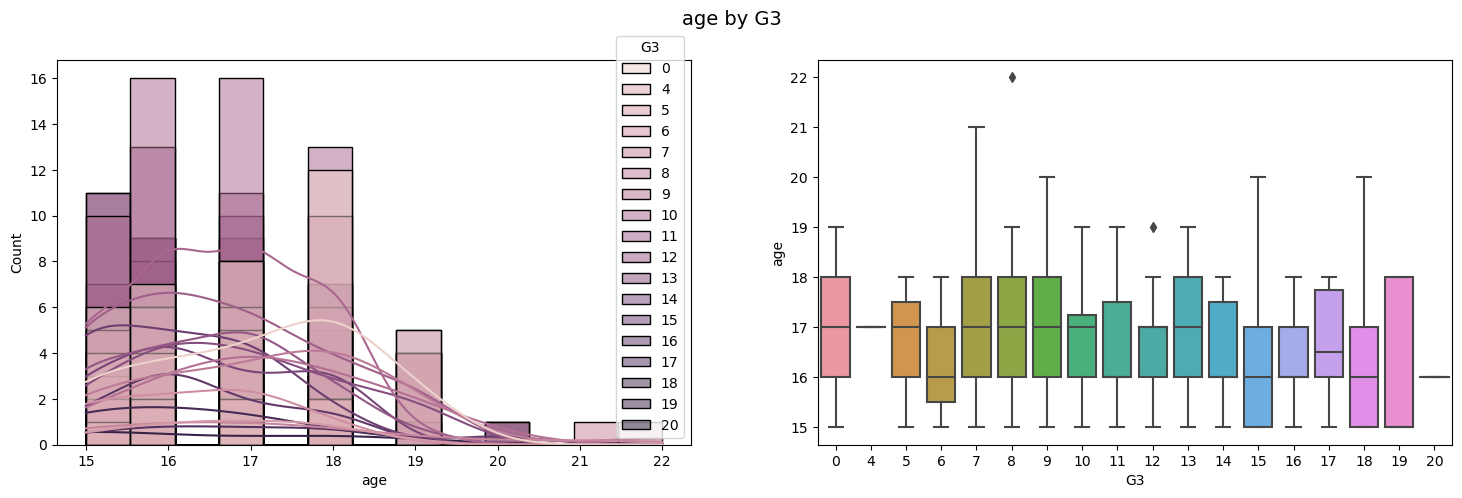

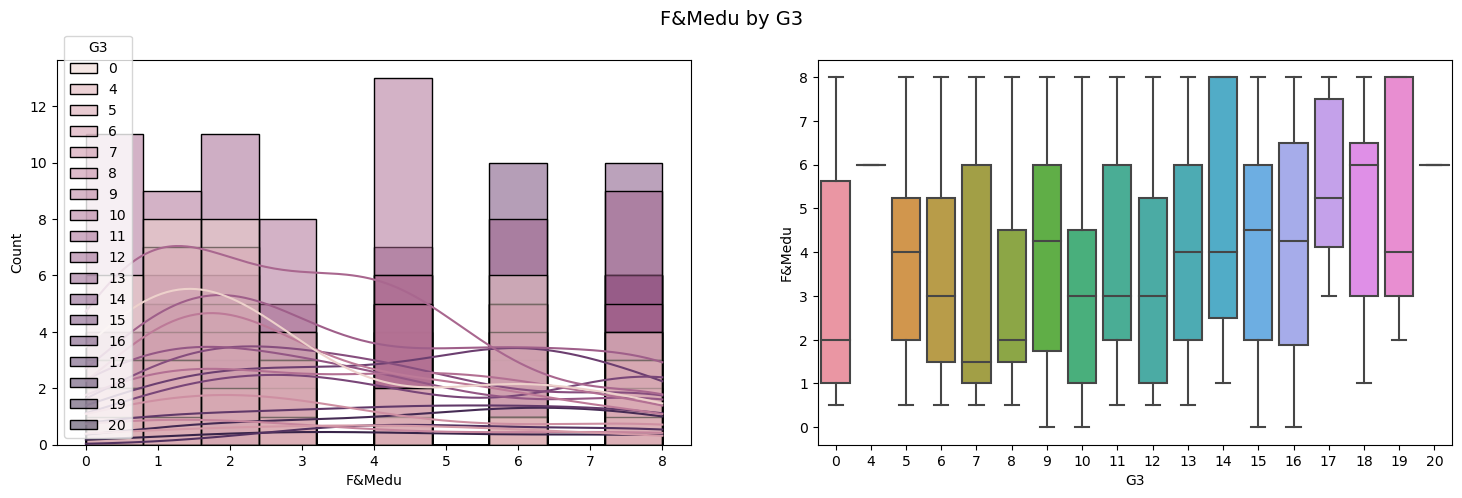

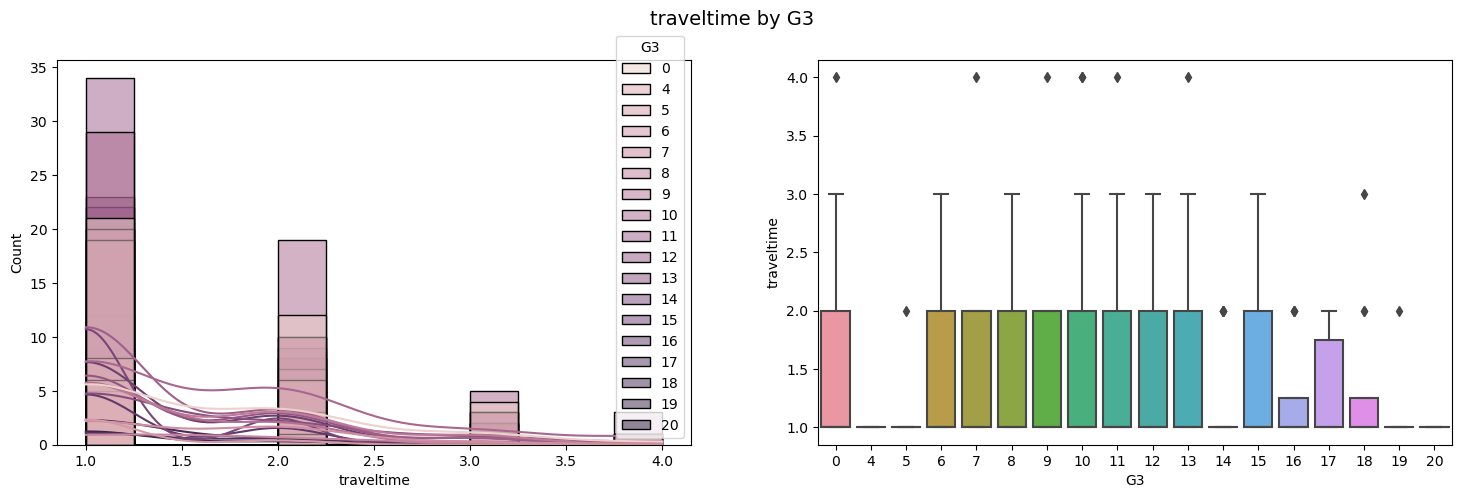

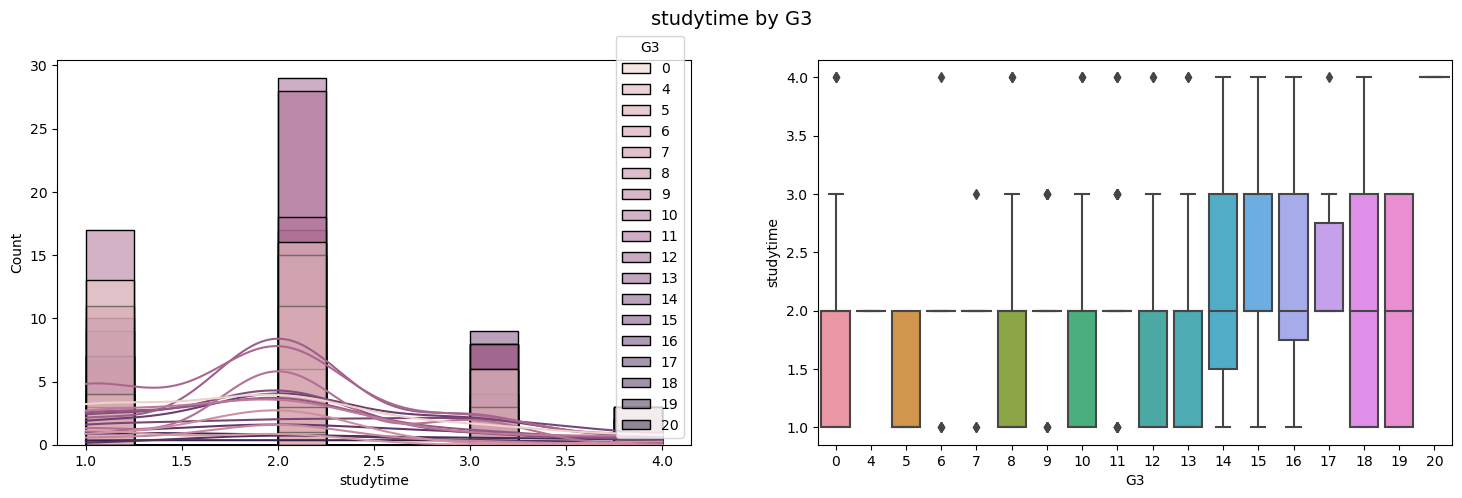

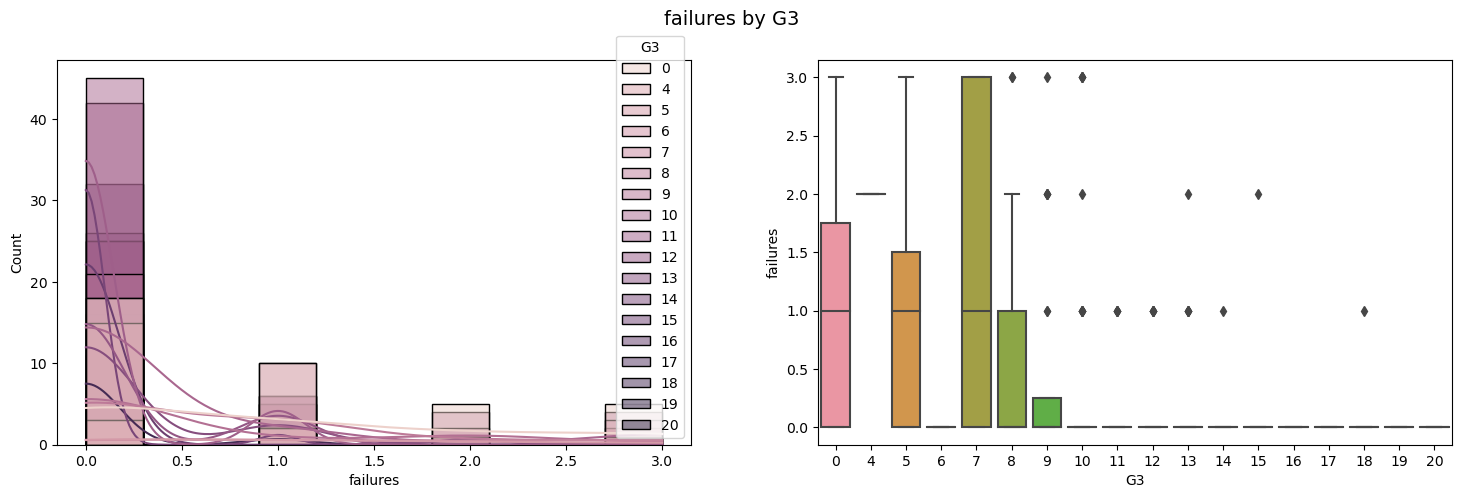

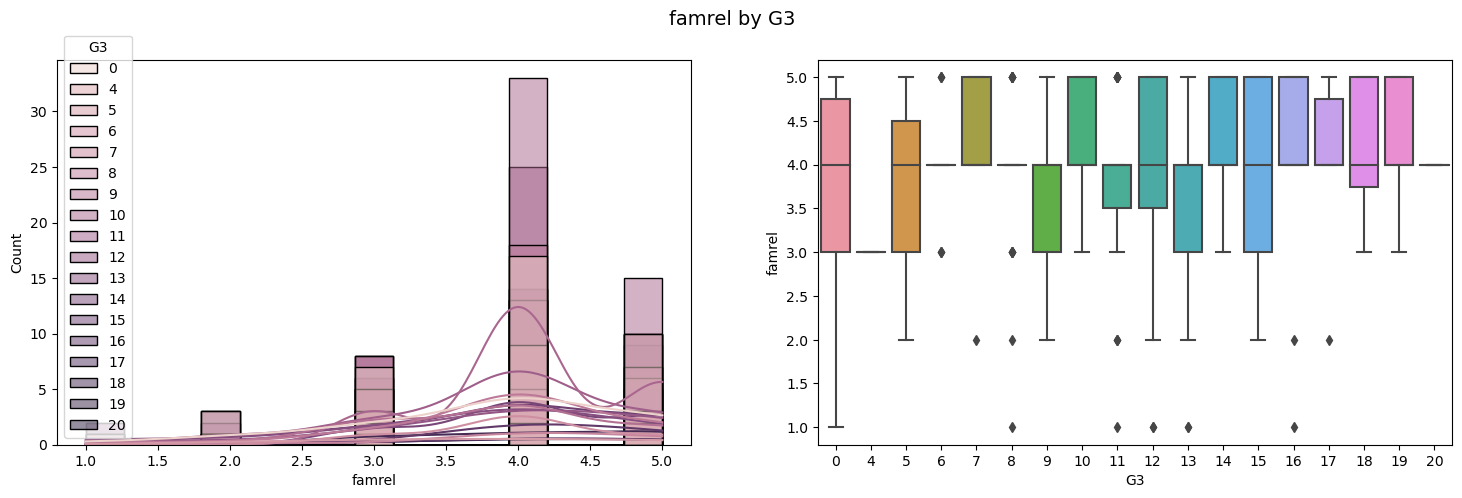

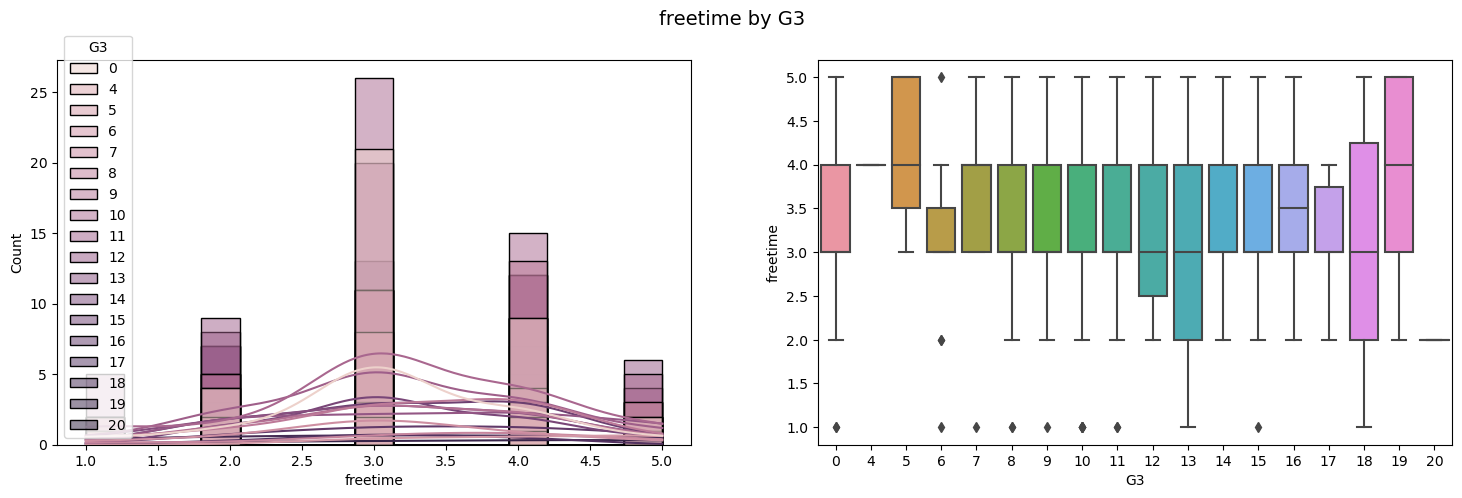

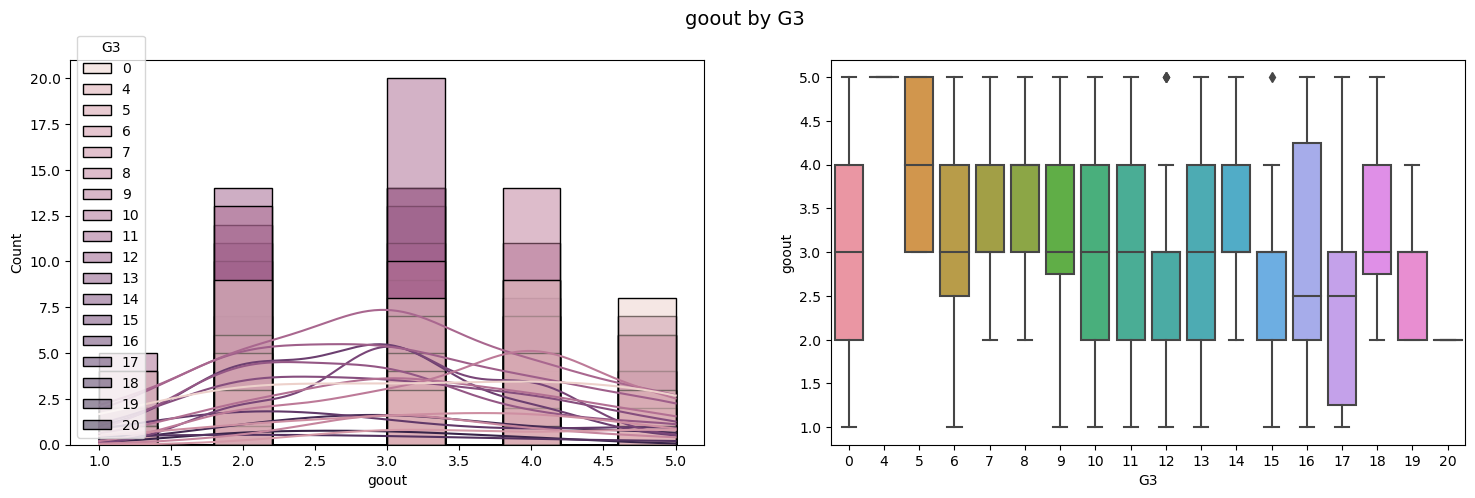

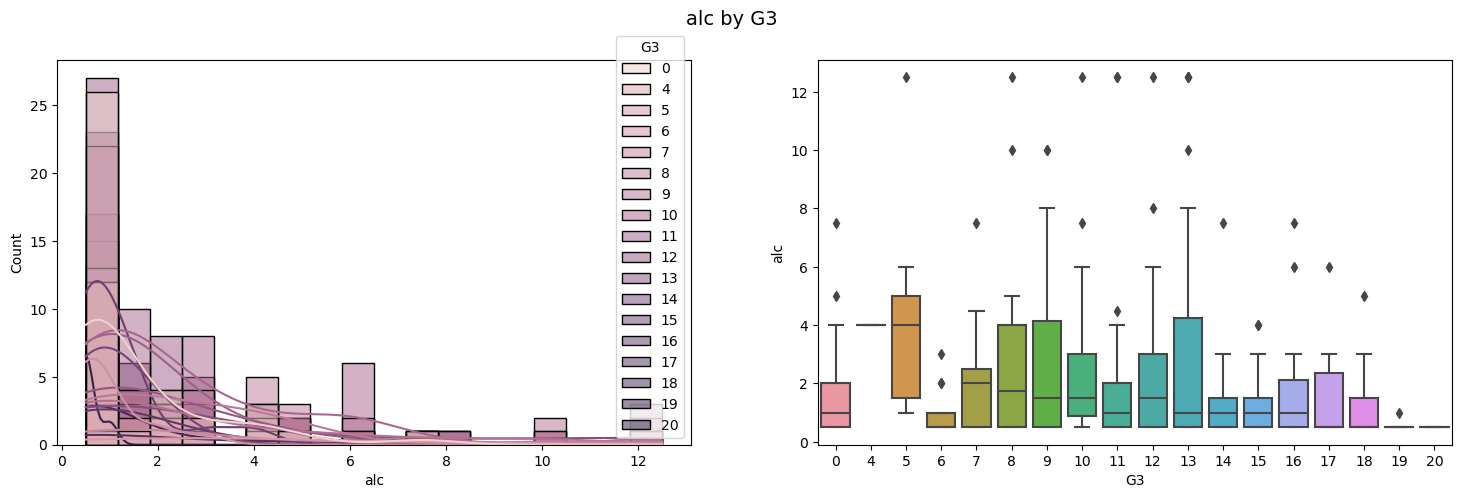

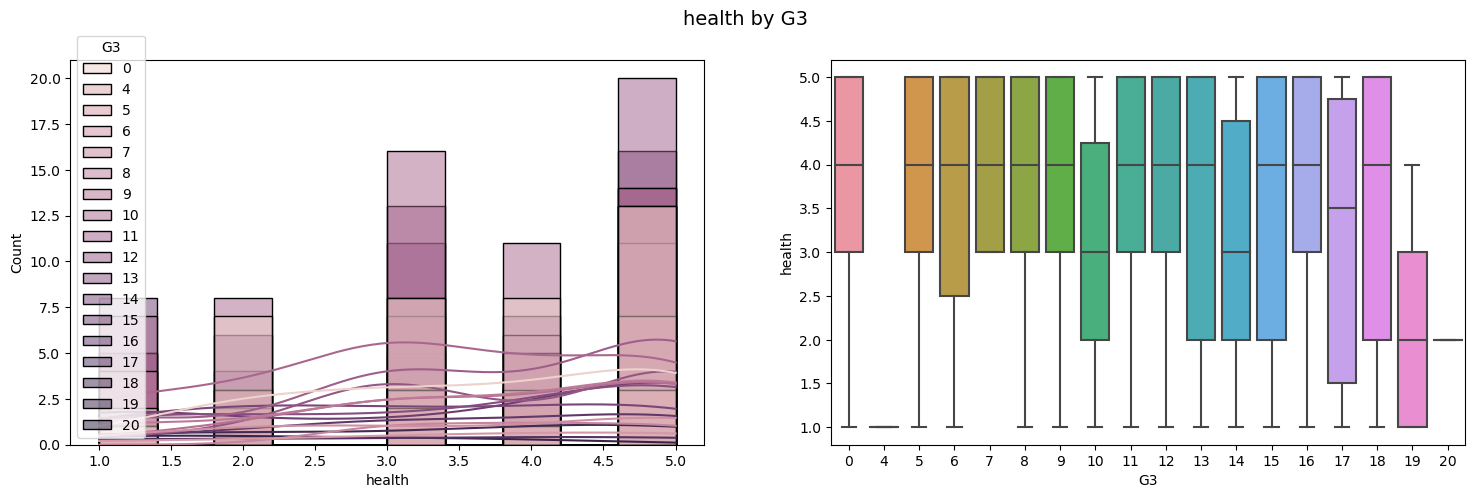

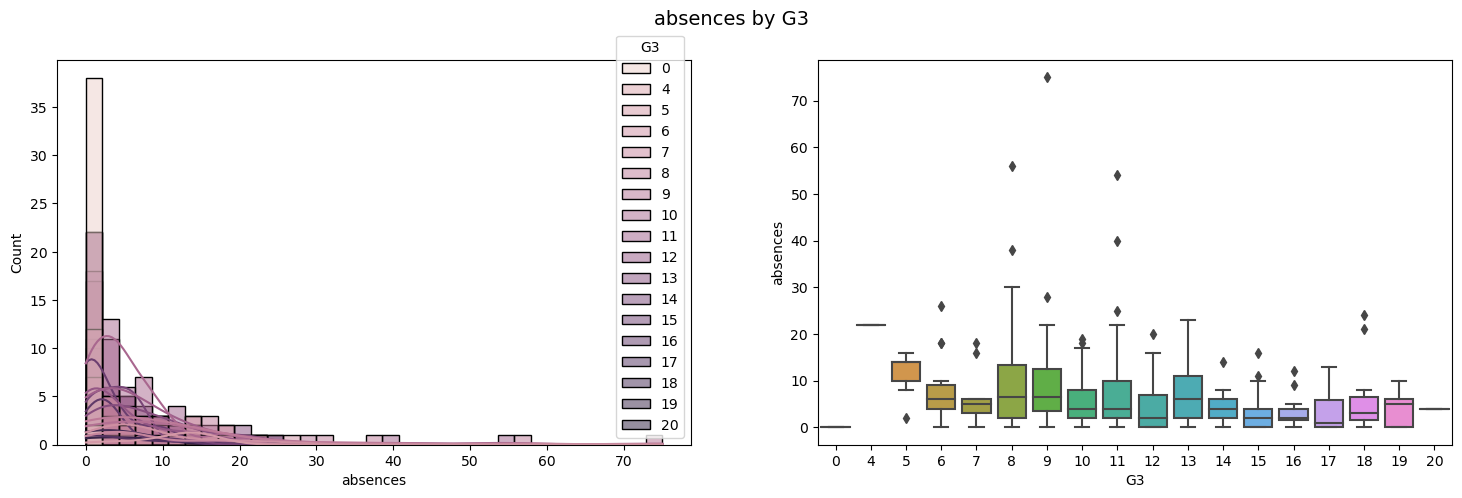

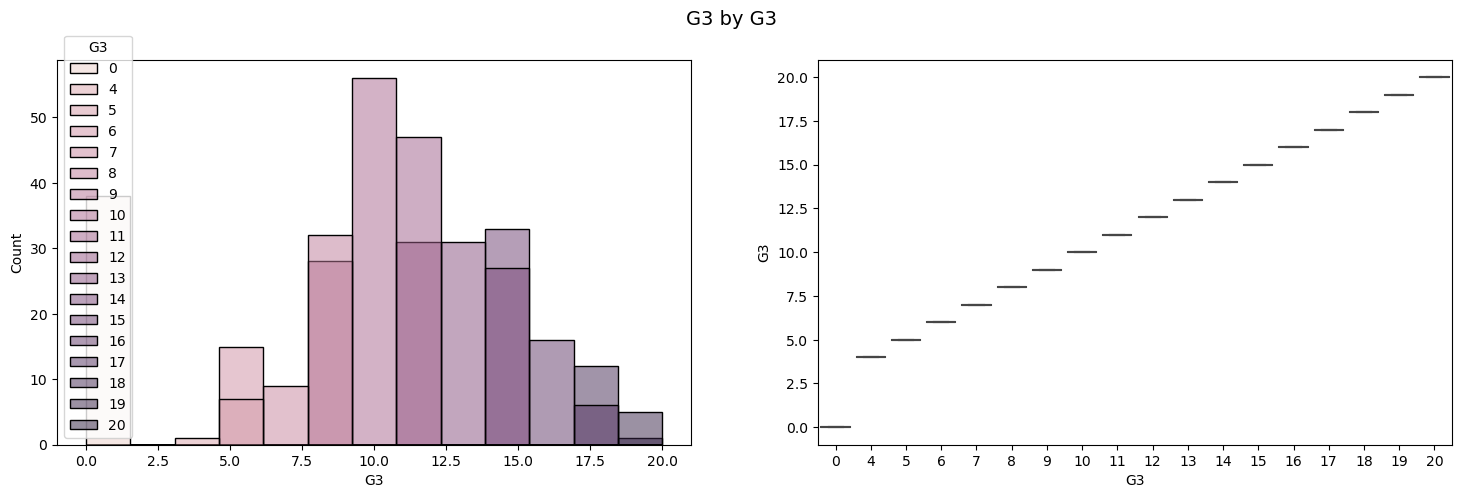

In [62]:
for col in num_cols:
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 5))
    sns.histplot(data=data_student, x=col, hue='G3', kde=True, ax=ax1)
    sns.boxplot(data=data_student, x='G3', y=col, ax=ax2)
    fig.suptitle(f'{col} by G3', fontsize=14)
    plt.show()

In [29]:
# Co ja tu widzę???
#wiek - wraz z wiekiem wzrasta ilość udarów - od 40, średnio 42+, pojeynczy wynik poniżej 20 (może się zdarzyć)
#glukoza - nie widzę szczególnego związku
#bmi - nie wiem co widać???

# 5. Korelacja

In [30]:
corr_P = data_student.corr("pearson", numeric_only=True)
corr_P.shape

(16, 16)

In [31]:
corr_P

age      Medu      Fedu  traveltime  studytime  failures  \
age         1.000000 -0.163658 -0.163438    0.070641  -0.004140  0.243665   
Medu       -0.163658  1.000000  0.623455   -0.171639   0.064944 -0.236680   
Fedu       -0.163438  0.623455  1.000000   -0.158194  -0.009175 -0.250408   
traveltime  0.070641 -0.171639 -0.158194    1.000000  -0.100909  0.092239   
studytime  -0.004140  0.064944 -0.009175   -0.100909   1.000000 -0.173563   
failures    0.243665 -0.236680 -0.250408    0.092239  -0.173563  1.000000   
famrel      0.053940 -0.003914 -0.001370   -0.016808   0.039731 -0.044337   
freetime    0.016434  0.030891 -0.012846   -0.017025  -0.143198  0.091987   
goout       0.126964  0.064094  0.043105    0.028540  -0.063904  0.124561   
Dalc        0.131125  0.019834  0.002386    0.138325  -0.196019  0.136047   
Walc        0.117276 -0.047123 -0.012631    0.134116  -0.253785  0.141962   
health     -0.062187 -0.046878  0.014742    0.007501  -0.075616  0.065827   
absences    0.175230  0.100285  0.024473   -0.012944  -0.062700  0.063726   
G1         -0.064081  0.205341  0.190270   -0.093040   0.160612 -0.354718   
G2         -0.143474  0.215527  0.164893   -0.153198   0.135880 -0.355896   
G3         -0.161579  0.217147  0.152457   -0.117142   0.097820 -0.360415   

              famrel  freetime     goout      Dalc      Walc    health  \
age         0.053940  0.016434  0.126964  0.131125  0.117276 -0.062187   
Medu       -0.003914  0.030891  0.064094  0.019834 -0.047123 -0.046878   
Fedu       -0.001370 -0.012846  0.043105  0.002386 -0.012631  0.014742   
traveltime -0.016808 -0.017025  0.028540  0.138325  0.134116  0.007501   
studytime   0.039731 -0.143198 -0.063904 -0.196019 -0.253785 -0.075616   
failures   -0.044337  0.091987  0.124561  0.136047  0.141962  0.065827   
famrel      1.000000  0.150701  0.064568 -0.077594 -0.113397  0.094056   
freetime    0.150701  1.000000  0.285019  0.209001  0.147822  0.075733   
goout       0.064568  0.285019  1.000000  0.266994  0.420386 -0.009577   
Dalc       -0.077594  0.209001  0.266994  1.000000  0.647544  0.077180   
Walc       -0.113397  0.147822  0.420386  0.647544  1.000000  0.092476   
health      0.094056  0.075733 -0.009577  0.077180  0.092476  1.000000   
absences   -0.044354 -0.058078  0.044302  0.111908  0.136291 -0.029937   
G1          0.022168  0.012613 -0.149104 -0.094159 -0.126179 -0.073172   
G2         -0.018281 -0.013777 -0.162250 -0.064120 -0.084927 -0.097720   
G3          0.051363  0.011307 -0.132791 -0.054660 -0.051939 -0.061335   

            absences        G1        G2        G3  
age         0.175230 -0.064081 -0.143474 -0.161579  
Medu        0.100285  0.205341  0.215527  0.217147  
Fedu        0.024473  0.190270  0.164893  0.152457  
traveltime -0.012944 -0.093040 -0.153198 -0.117142  
studytime  -0.062700  0.160612  0.135880  0.097820  
failures    0.063726 -0.354718 -0.355896 -0.360415  
famrel     -0.044354  0.022168 -0.018281  0.051363  
freetime   -0.058078  0.012613 -0.013777  0.011307  
goout       0.044302 -0.149104 -0.162250 -0.132791  
Dalc        0.111908 -0.094159 -0.064120 -0.054660  
Walc        0.136291 -0.126179 -0.084927 -0.051939  
health     -0.029937 -0.073172 -0.097720 -0.061335  
absences    1.000000 -0.031003 -0.031777  0.034247  
G1         -0.031003  1.000000  0.852118  0.801468  
G2         -0.031777  0.852118  1.000000  0.904868  
G3          0.034247  0.801468  0.904868  1.000000

In [32]:
corr_P_tri = corr_P.where(np.triu(np.ones(corr_P.shape, dtype=bool), k=1)).stack().sort_values()
corr_P_tri

failures   G3         -0.360415
           G2         -0.355896
           G1         -0.354718
studytime  Walc       -0.253785
Fedu       failures   -0.250408
                         ...   
Medu       Fedu        0.623455
Dalc       Walc        0.647544
G1         G3          0.801468
           G2          0.852118
G2         G3          0.904868
Length: 120, dtype: float64

In [33]:
corr_P_tri[abs(corr_P_tri)>0.4]

goout  Walc    0.420386
Medu   Fedu    0.623455
Dalc   Walc    0.647544
G1     G3      0.801468
       G2      0.852118
G2     G3      0.904868
dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


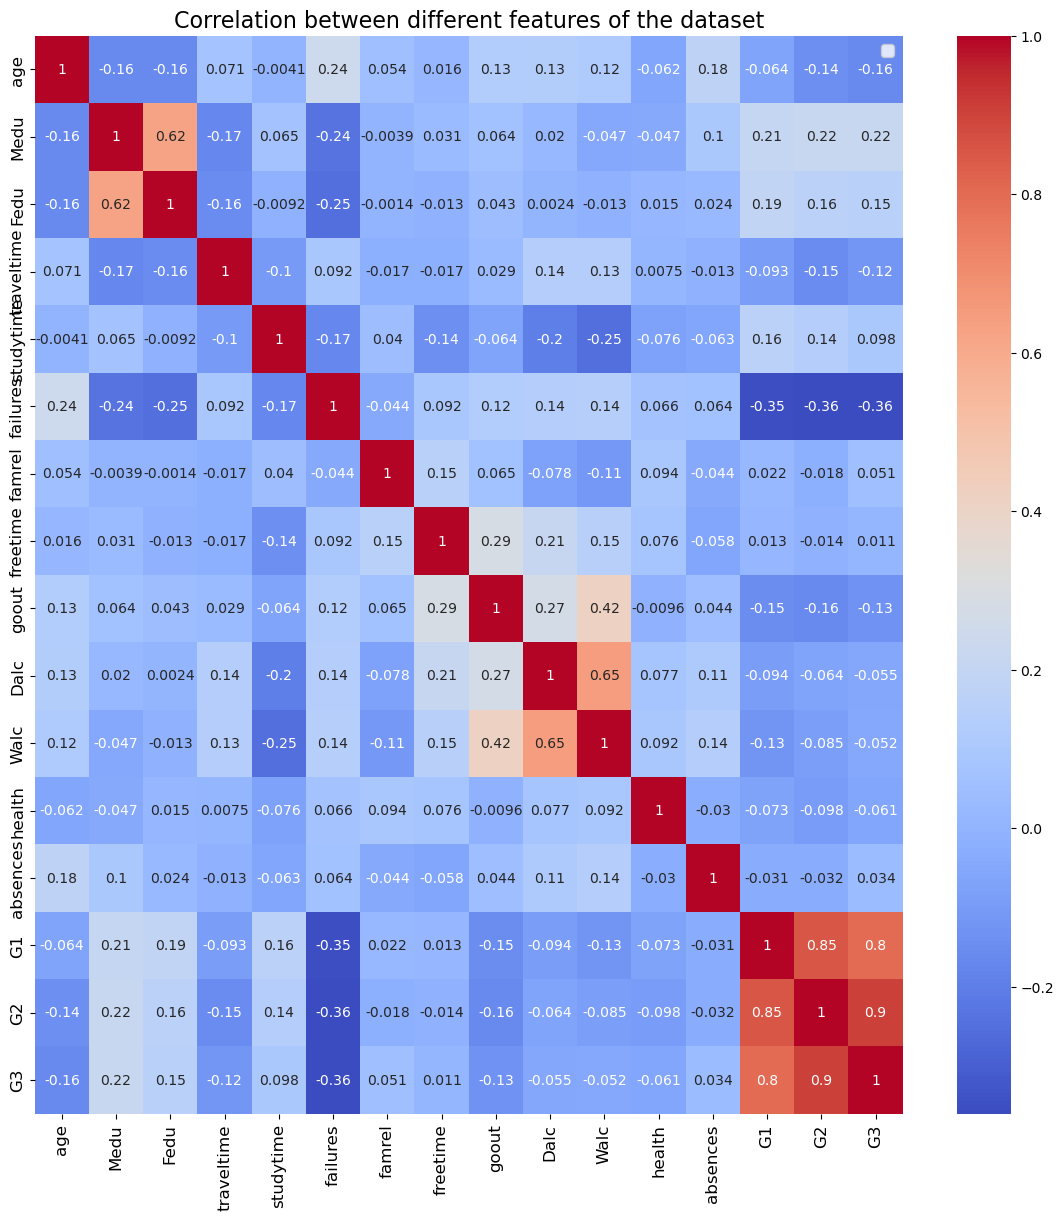

In [34]:
#Sprawdzam ewentualną korelację 
plt.figure(figsize = (14,14))
plt.title("Correlation between different features of the dataset", fontsize = 16)
sns.heatmap(data_student.corr(numeric_only = True), cmap = 'coolwarm', annot = True)
plt.xticks(fontsize=12, rotation = 90)
plt.yticks(fontsize=12, rotation = 90)
plt.legend(fontsize=12)



In [35]:
#data_numeric = data_student.loc[:, num_cols]
#sns.pairplot(data_numeric, hue = "G3", diag_kind = "kde")
#plt.show()

G1, G2 z G3
Fedu z Medu
Walz z Malz
Walc z GOout


In [36]:
#usuwam kolunmy g1, g2,
# z kol Medu i Pedu zrobię średnią
#z kol Walc i Dalc zrobię średnią


In [37]:
#usuwam kolunmy g1, g2 - są silnie skorelowane z G3

In [38]:
data_student.drop(columns='G1', inplace=True)
data_student.drop(columns='G2', inplace=True)
data_student.head()

school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  internet romantic  famrel  freetime  goout Dalc Walc health absences  G3  
0       no       no       4         3      4    1    1      3        6   6  
1      yes       no       5         3      3    1    1      3        4   6  
2      yes       no       4         3      2    2    3      3       10  10  
3      yes      yes       3         2      2    1    1      5        2  15  
4       no       no       4         3      2    1    2      5        4  10  

[5 rows x 31 columns]

In [39]:
#z kol Medu i Fedu zrobię średnią - wtedy otrzymam średnią miedzy wykształceniem rodziców
#z kol Walc i Dalc zrobię średnią - średnią picia alkoholu w tygodniu
# i usunę kolumny Medu i Fedu, Walc i Dalc

In [40]:
data_student['F&Medu'] = data_student.apply(lambda row: row['Fedu']*row['Medu']/2, axis = 1)
data_student['alc'] = data_student.apply(lambda row: row['Walc']*row['Dalc']/2, axis = 1)
data_student.drop(columns='Fedu', inplace=True)
data_student.drop(columns='Medu', inplace=True)
data_student.drop(columns='Walc', inplace=True)
data_student.drop(columns='Dalc', inplace=True)

In [41]:
data_student.head()

school sex  age address famsize Pstatus     Mjob      Fjob  reason guardian  \
0     GP   F   18       U     GT3       A  at_home   teacher  course   mother   
1     GP   F   17       U     GT3       T  at_home     other  course   father   
2     GP   F   15       U     LE3       T  at_home     other   other   mother   
3     GP   F   15       U     GT3       T   health  services    home   mother   
4     GP   F   16       U     GT3       T    other     other    home   father   

   ...  internet  romantic  famrel freetime goout health absences  G3 F&Medu  \
0  ...        no        no       4        3     4      3        6   6    8.0   
1  ...       yes        no       5        3     3      3        4   6    0.5   
2  ...       yes        no       4        3     2      3       10  10    0.5   
3  ...       yes       yes       3        2     2      5        2  15    4.0   
4  ...        no        no       4        3     2      5        4  10    4.5   

   alc  
0  0.5  
1  0.5  
2  3.0  
3  0.5  
4  1.0  

[5 rows x 29 columns]

In [42]:
# przesunąć kolumny ostatnie przed G3

# 6. Wykresy

In [56]:
# definiuję na nowo cat_cols, i num_cols
num_cols = ['age', 'F&Medu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout',
            'alc', 'health', 'absences', 'G3']
cat_cols = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 
            'famsup', 'paid', 'activities', 'nursery', 'romantic']

In [57]:
def generate_plots_and_tables_by_tagret(df: pd.DataFrame, target_column: str = "DefFlag",
                                        num_cols: list = [], cat_cols: list = []) -> None:
    """
    Generate plots of the 'target_column' column with other columns in a pandas dataframe.
    If a column is a string or factor, a bar plot with grouping by 'target_column' will be created.
    If a column is continuous, a histogram, boxplot, and scatter plot with grouping by 'target_column' will be created.
    """
    for column in cat_cols:
        print(column + ":")
        
        plt.figure(figsize=(15, 6))
            
        counts = df.groupby([column, target_column], group_keys=True).size()
        print(counts)
        counts_norm = counts.groupby(level=0, group_keys=False).apply(lambda x: 100 * x / x.sum())
        counts_norm = counts_norm.reset_index(name='percent')
        sns.barplot(x=column, y='percent', hue=target_column, data=counts_norm)
        plt.title(f"'G3' vs '{column}'")
        plt.show()
            
    for column in num_cols:
        
        plt.figure(figsize=(12, 6))
            
        plt.subplot(1, 2, 1)
        sns.histplot(x=column, hue=target_column, data=df, kde=True)
        plt.title(f"'G3' vs '{column}' (Histogram)")
            
        plt.subplot(1, 2, 2)
        sns.boxplot(x=target_column, y=column, data=df)
        plt.title(f"'G3' vs '{column}' (Boxplot)")
            
        plt.tight_layout()
        plt.show()

school:
school  G3
GP      0     34
        4      1
        5      5
        6     14
        7      7
        8     28
        9     24
        10    46
        11    43
        12    28
        13    26
        14    26
        15    30
        16    14
        17     6
        18    12
        19     4
        20     1
MS      0      4
        5      2
        6      1
        7      2
        8      4
        9      4
        10    10
        11     4
        12     3
        13     5
        14     1
        15     3
        16     2
        19     1
dtype: int64


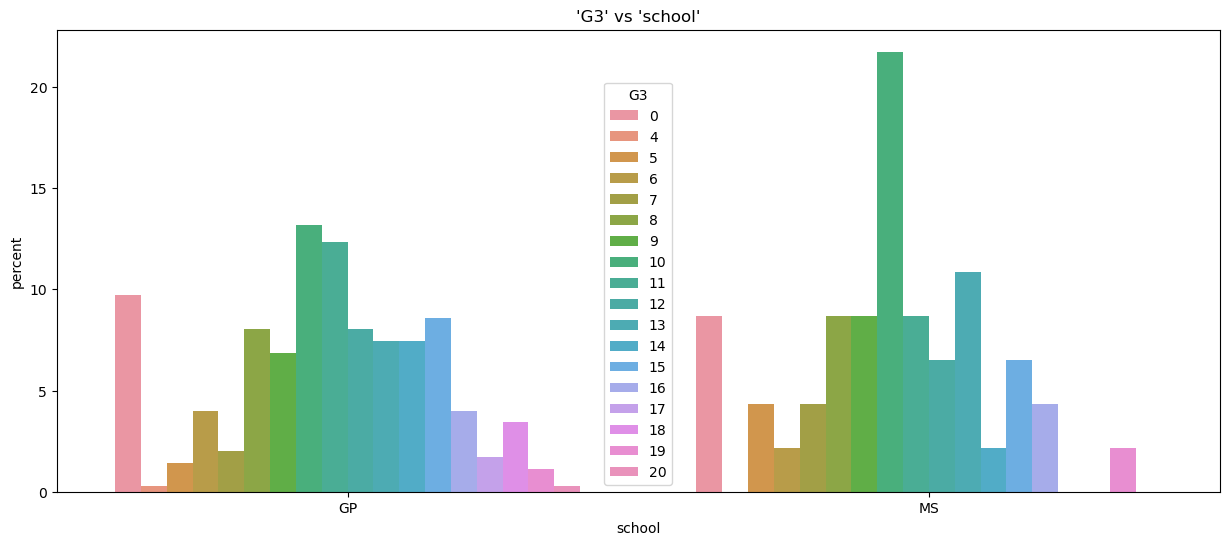

sex:
sex  G3
F    0     23
     4      1
     5      3
     6     13
     7      4
     8     14
     9     17
     10    30
     11    29
     12    11
     13    17
     14    14
     15    16
     16     6
     17     3
     18     5
     19     2
M    0     15
     5      4
     6      2
     7      5
     8     18
     9     11
     10    26
     11    18
     12    20
     13    14
     14    13
     15    17
     16    10
     17     3
     18     7
     19     3
     20     1
dtype: int64


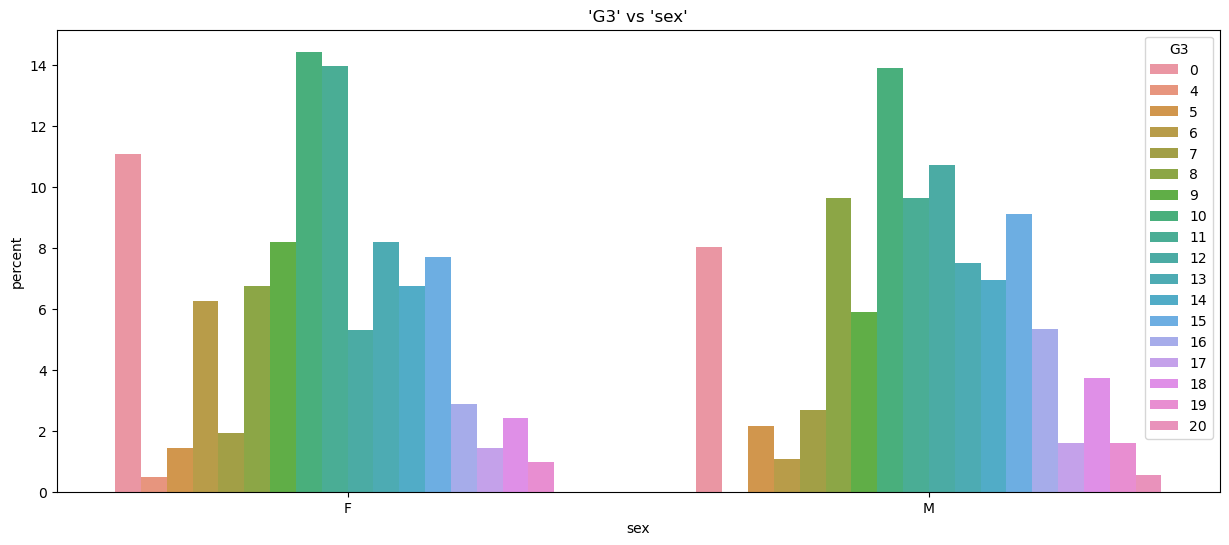

address:
address  G3
R        0     10
         5      4
         6      3
         7      6
         8      7
         9      3
         10    17
         11    10
         12     8
         13     7
         14     3
         15     3
         16     3
         17     1
         18     2
         19     1
U        0     28
         4      1
         5      3
         6     12
         7      3
         8     25
         9     25
         10    39
         11    37
         12    23
         13    24
         14    24
         15    30
         16    13
         17     5
         18    10
         19     4
         20     1
dtype: int64


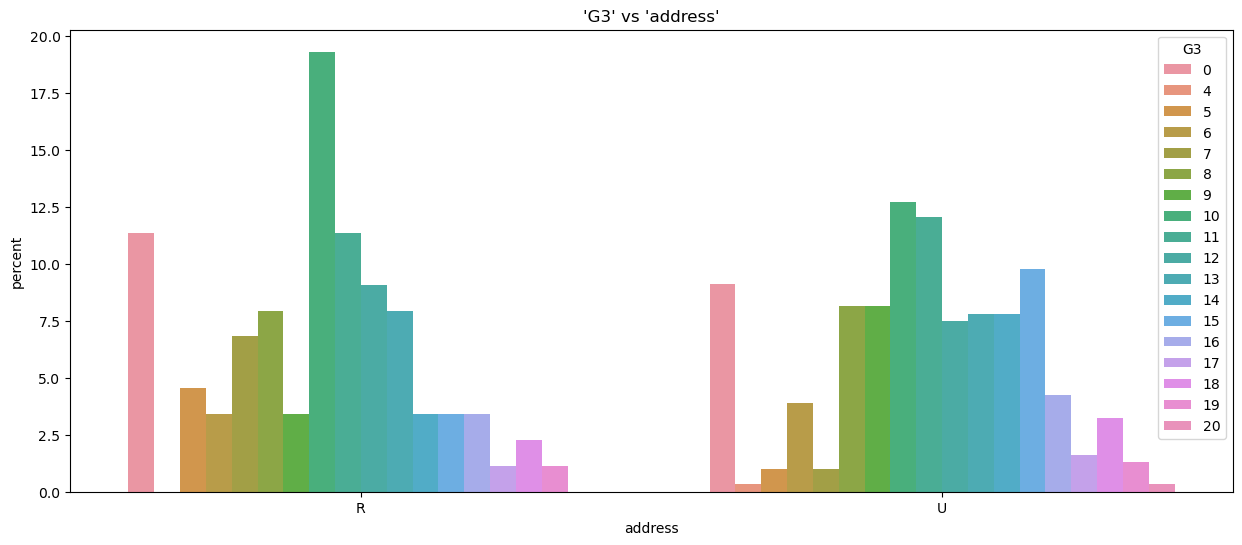

famsize:
famsize  G3
GT3      0     31
         4      1
         5      6
         6     10
         7      7
         8     23
         9     18
         10    40
         11    36
         12    19
         13    19
         14    22
         15    23
         16    10
         17     4
         18    10
         19     1
         20     1
LE3      0      7
         5      1
         6      5
         7      2
         8      9
         9     10
         10    16
         11    11
         12    12
         13    12
         14     5
         15    10
         16     6
         17     2
         18     2
         19     4
dtype: int64


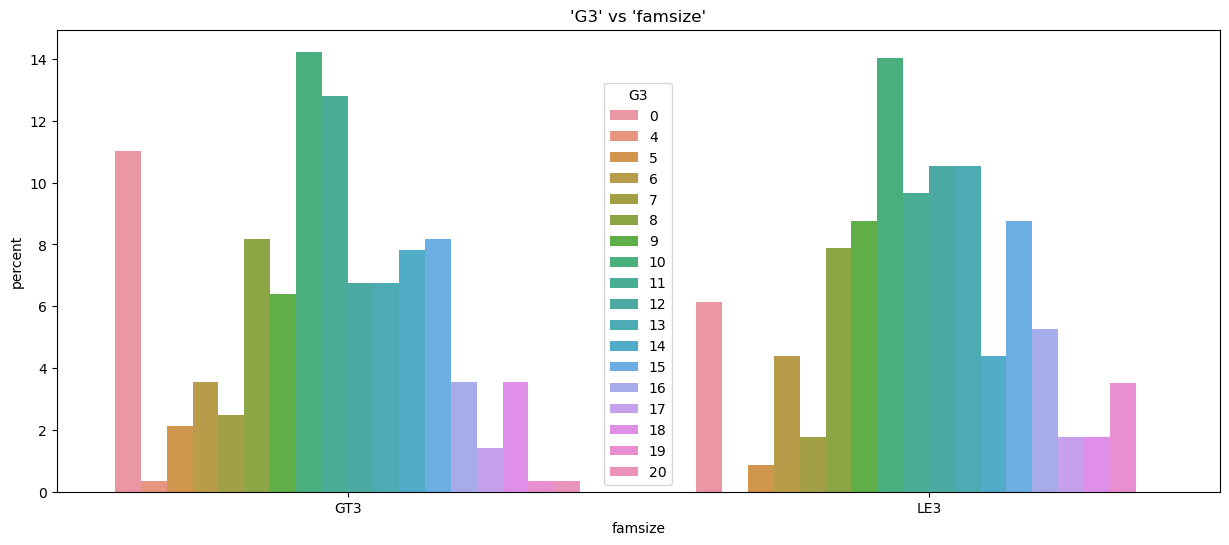

Pstatus:
Pstatus  G3
A        0      2
         6      3
         7      2
         8      1
         9      3
         10     5
         11     8
         12     3
         13     4
         14     1
         15     3
         16     1
         17     1
         18     2
         19     2
T        0     36
         4      1
         5      7
         6     12
         7      7
         8     31
         9     25
         10    51
         11    39
         12    28
         13    27
         14    26
         15    30
         16    15
         17     5
         18    10
         19     3
         20     1
dtype: int64


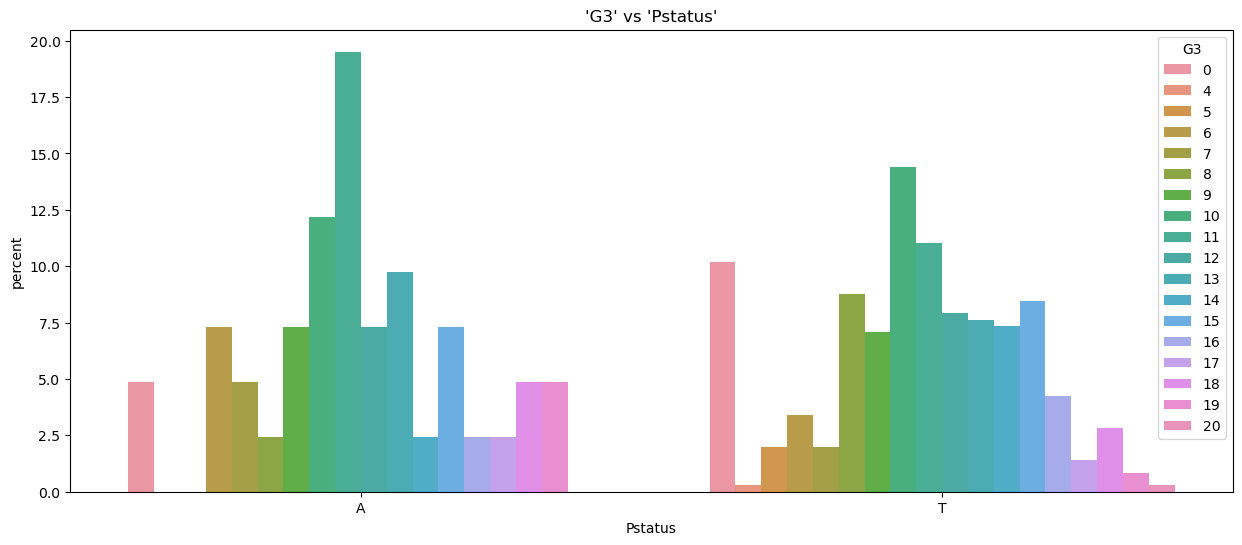

Mjob:
Mjob     G3
at_home  0     9
         5     1
         6     4
         8     4
         9     4
              ..
teacher  14    4
         15    5
         16    5
         18    2
         19    2
Length: 72, dtype: int64


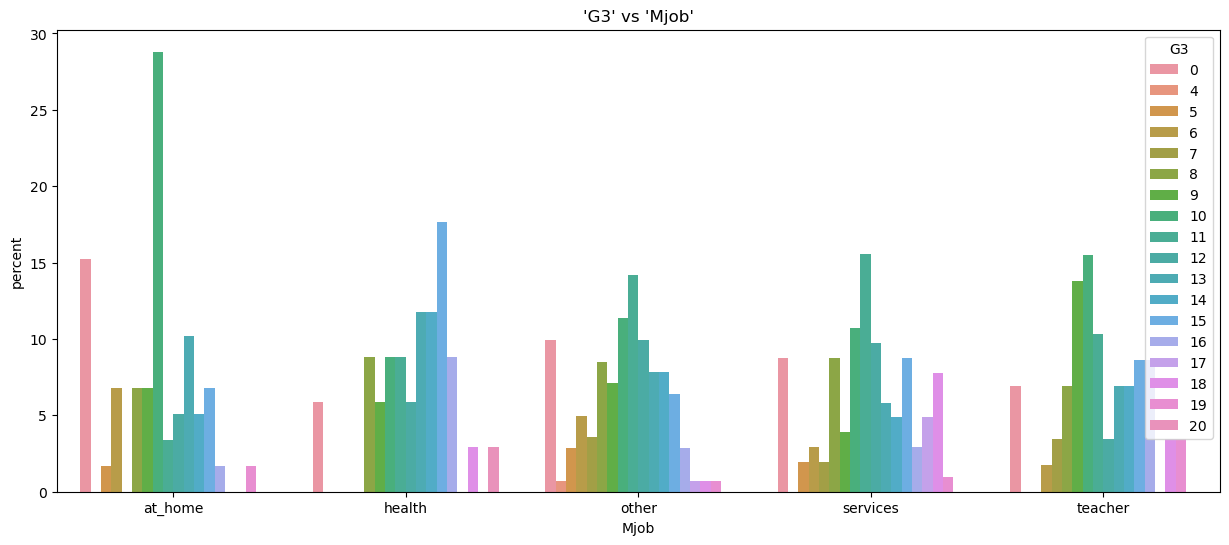

Fjob:
Fjob     G3
at_home  0     3
         6     1
         8     1
         9     3
         10    1
              ..
teacher  15    3
         16    3
         17    2
         18    3
         19    1
Length: 68, dtype: int64


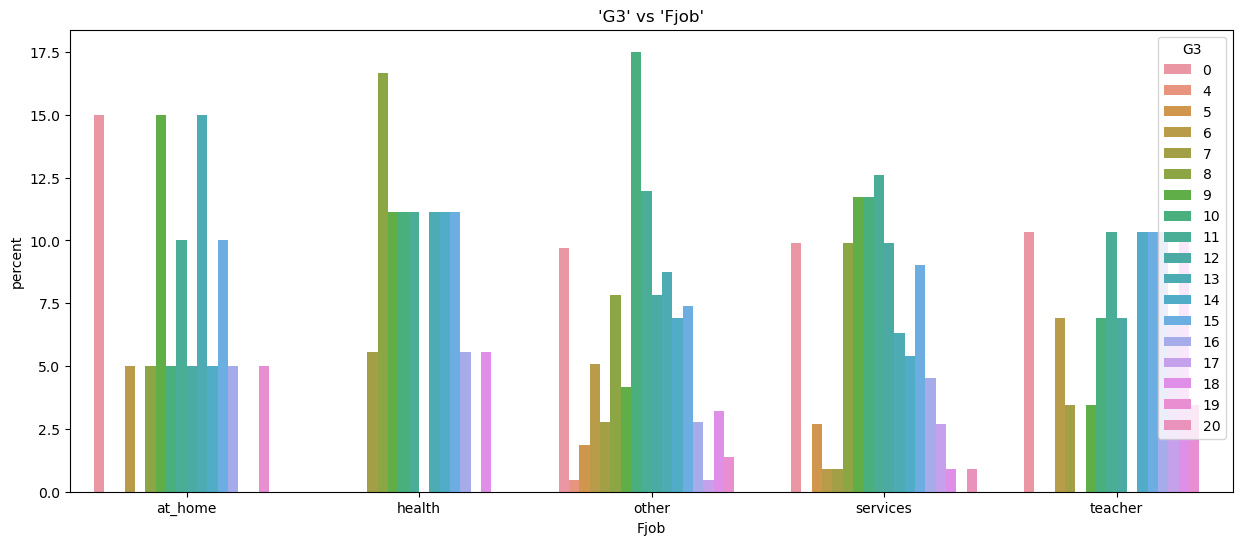

reason:
reason      G3
course      0     19
            5      4
            6      5
            7      4
            8     12
                  ..
reputation  16     3
            17     3
            18     3
            19     1
            20     1
Length: 63, dtype: int64


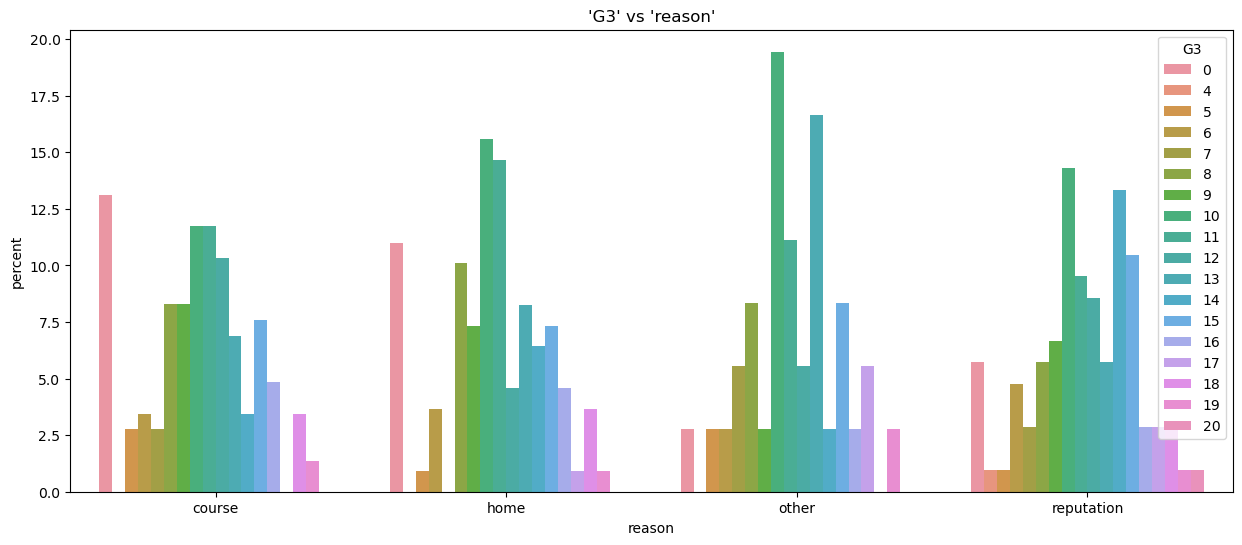

guardian:
guardian  G3
father    0      8
          5      1
          6      4
          7      1
          8      5
          9      6
          10    16
          11     8
          12     9
          13     8
          14     8
          15     6
          16     4
          17     2
          18     4
mother    0     25
          4      1
          5      6
          6     11
          7      7
          8     21
          9     18
          10    37
          11    35
          12    20
          13    19
          14    19
          15    26
          16    11
          17     4
          18     7
          19     5
          20     1
other     0      5
          7      1
          8      6
          9      4
          10     3
          11     4
          12     2
          13     4
          15     1
          16     1
          18     1
dtype: int64


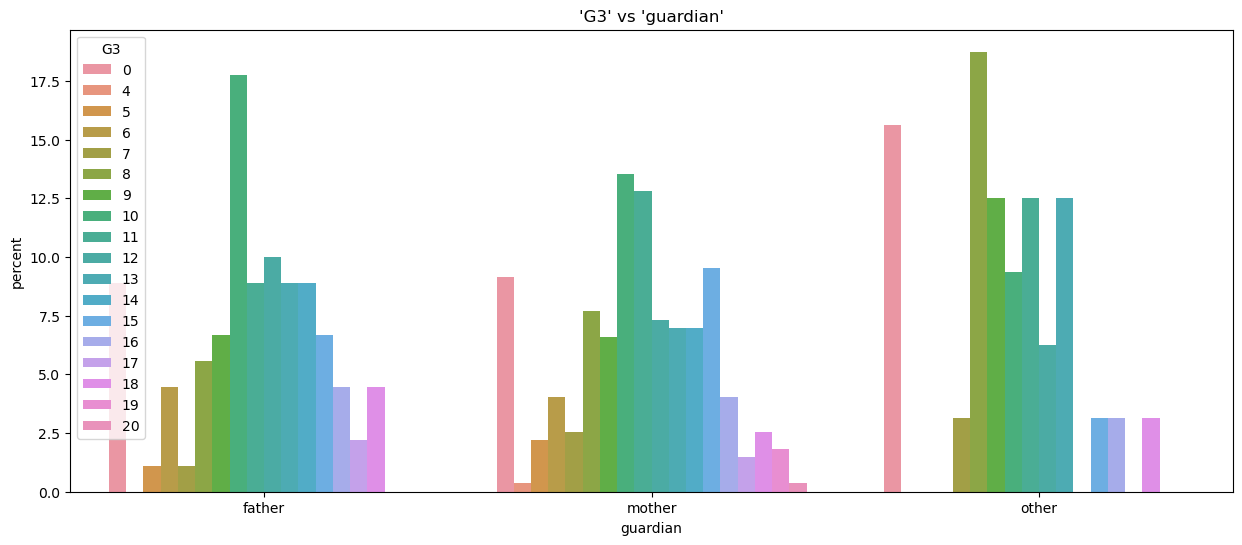

schoolsup:
schoolsup  G3
no         0     37
           4      1
           5      5
           6      9
           7      7
           8     26
           9     22
           10    46
           11    38
           12    27
           13    29
           14    26
           15    32
           16    16
           17     5
           18    12
           19     5
           20     1
yes        0      1
           5      2
           6      6
           7      2
           8      6
           9      6
           10    10
           11     9
           12     4
           13     2
           14     1
           15     1
           17     1
dtype: int64


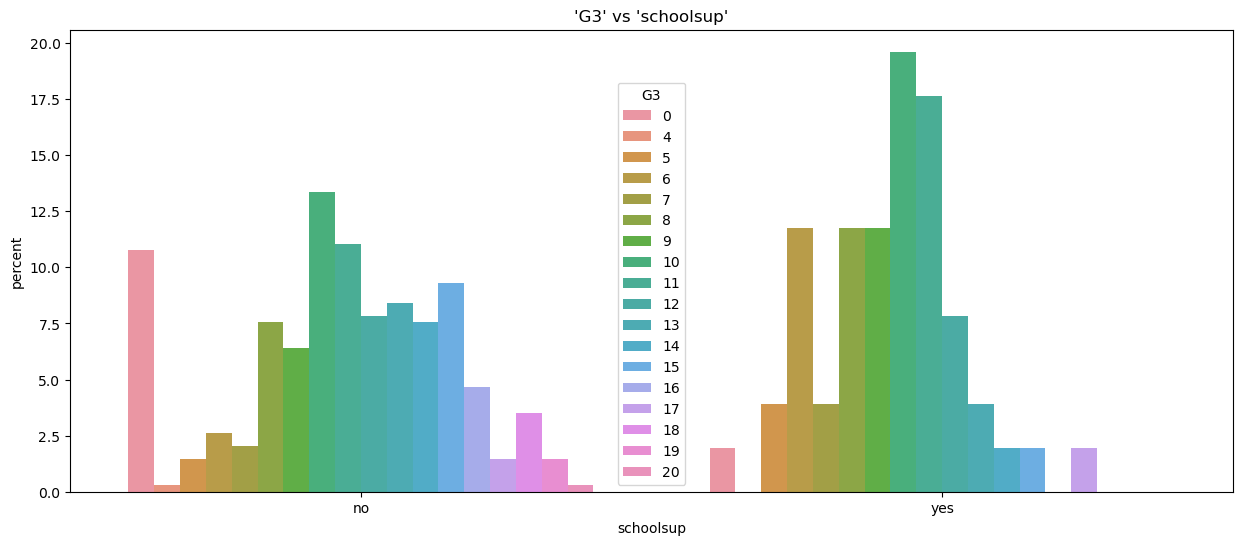

famsup:
famsup  G3
no      0     15
        4      1
        5      2
        6      2
        7      4
        8     11
        9     10
        10    24
        11    16
        12    13
        13    15
        14     9
        15    15
        16     7
        17     1
        18     4
        19     3
        20     1
yes     0     23
        5      5
        6     13
        7      5
        8     21
        9     18
        10    32
        11    31
        12    18
        13    16
        14    18
        15    18
        16     9
        17     5
        18     8
        19     2
dtype: int64


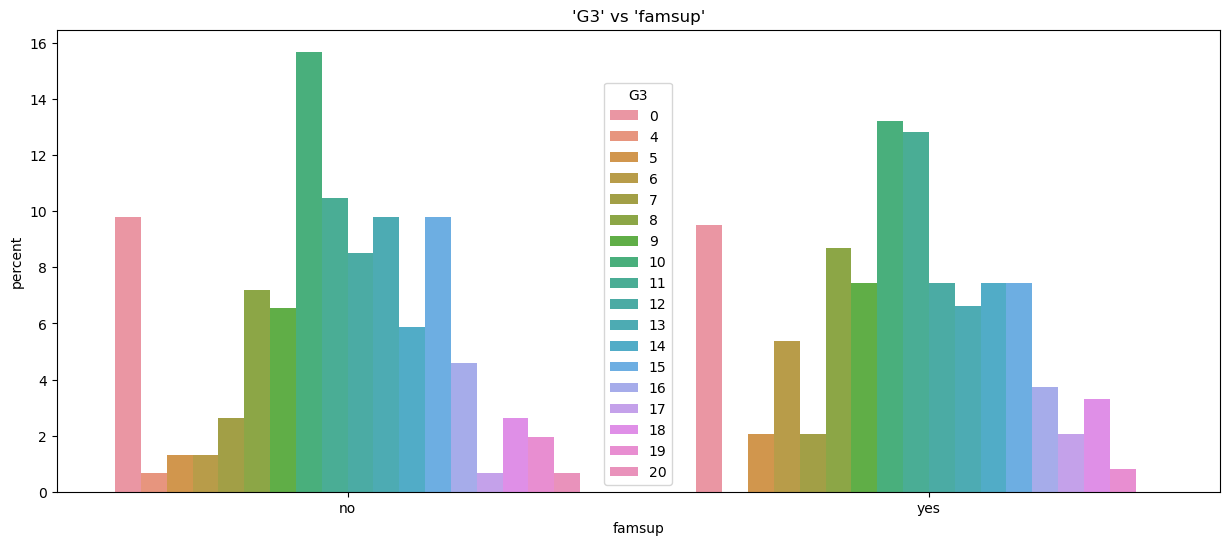

paid:
paid  G3
no    0     30
      5      5
      6      9
      7      7
      8     12
      9     16
      10    26
      11    21
      12    19
      13    14
      14    14
      15    14
      16    12
      17     5
      18     6
      19     3
      20     1
yes   0      8
      4      1
      5      2
      6      6
      7      2
      8     20
      9     12
      10    30
      11    26
      12    12
      13    17
      14    13
      15    19
      16     4
      17     1
      18     6
      19     2
dtype: int64


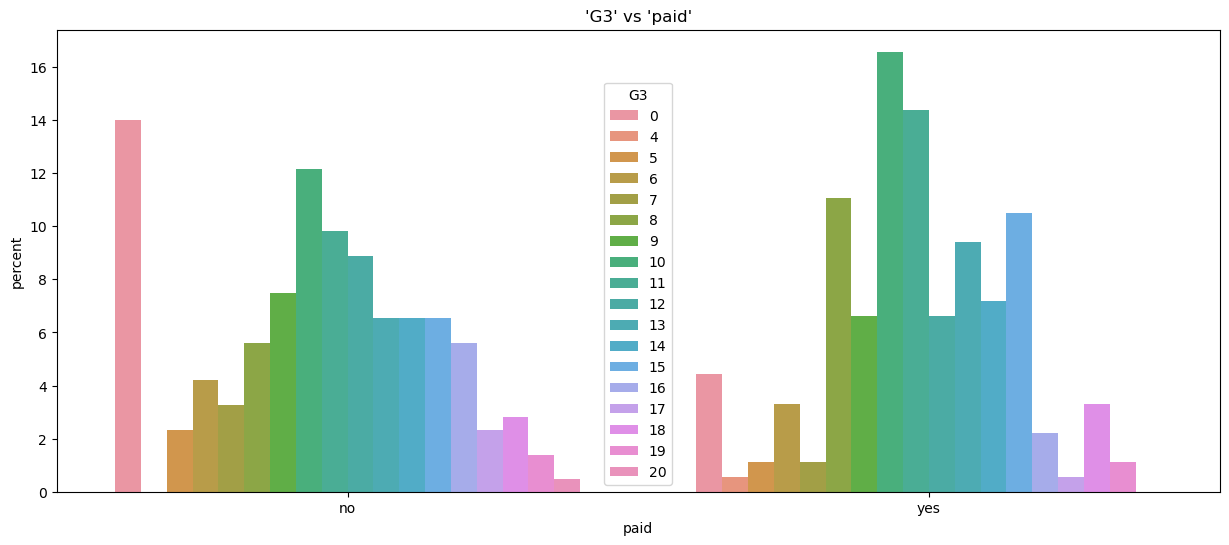

activities:
activities  G3
no          0     17
            4      1
            5      4
            6     10
            7      4
            8     19
            9     10
            10    27
            11    24
            12    15
            13    19
            14    10
            15    15
            16     9
            17     2
            18     4
            19     4
yes         0     21
            5      3
            6      5
            7      5
            8     13
            9     18
            10    29
            11    23
            12    16
            13    12
            14    17
            15    18
            16     7
            17     4
            18     8
            19     1
            20     1
dtype: int64


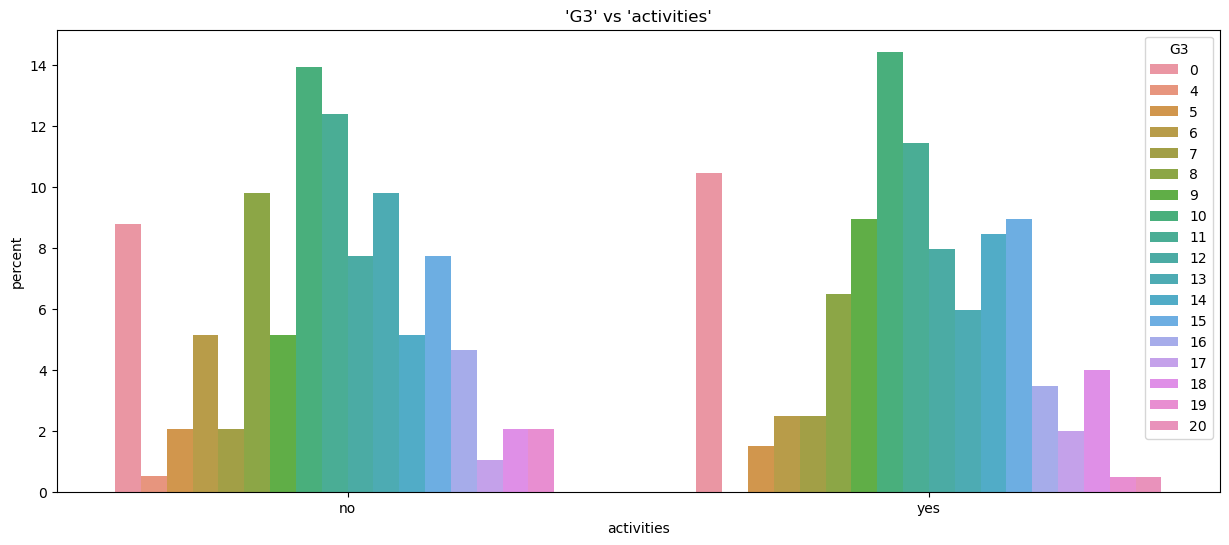

nursery:
nursery  G3
no       0     10
         5      1
         6      2
         7      3
         8      6
         9      4
         10    10
         11    13
         12    11
         13     3
         14     6
         15     8
         16     3
         18     1
yes      0     28
         4      1
         5      6
         6     13
         7      6
         8     26
         9     24
         10    46
         11    34
         12    20
         13    28
         14    21
         15    25
         16    13
         17     6
         18    11
         19     5
         20     1
dtype: int64


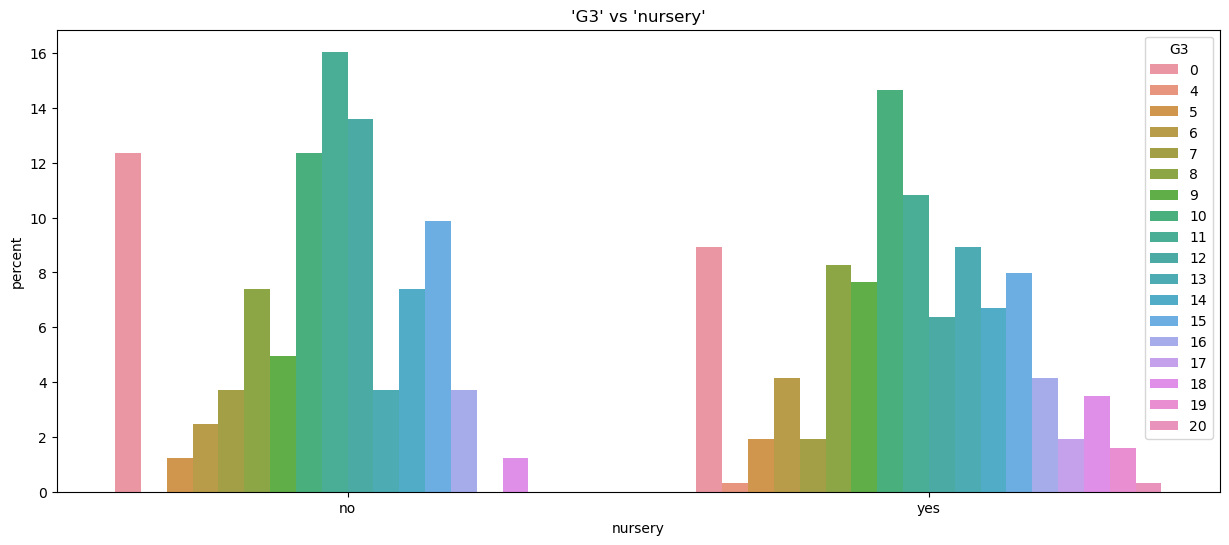

romantic:
romantic  G3
no        0     18
          5      5
          6     13
          7      4
          8     22
          9     16
          10    45
          11    30
          12    17
          13    19
          14    19
          15    24
          16     9
          17     5
          18    11
          19     5
          20     1
yes       0     20
          4      1
          5      2
          6      2
          7      5
          8     10
          9     12
          10    11
          11    17
          12    14
          13    12
          14     8
          15     9
          16     7
          17     1
          18     1
dtype: int64


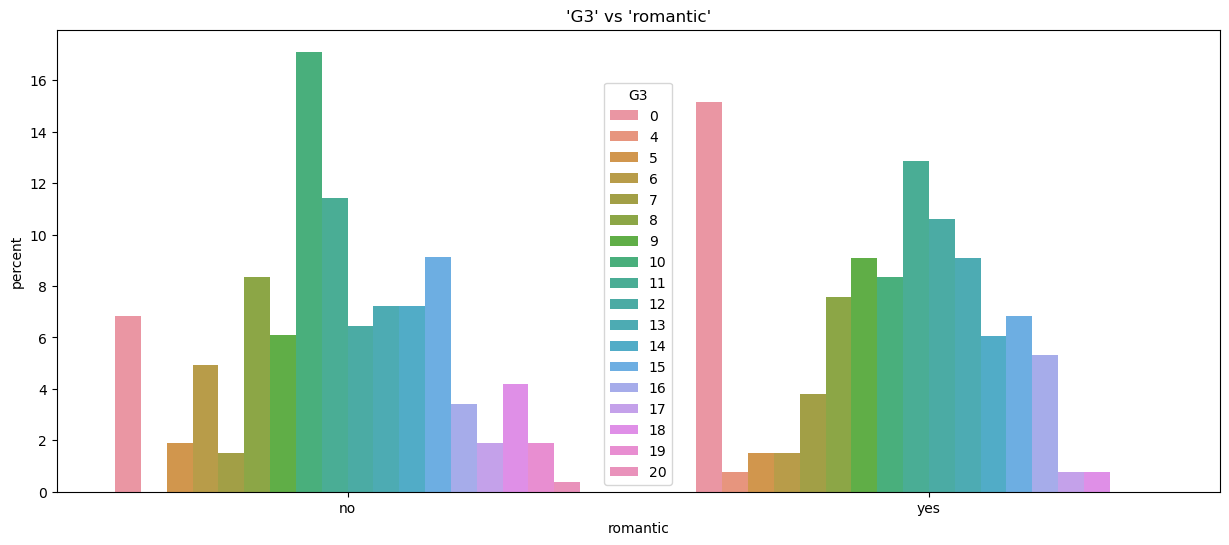

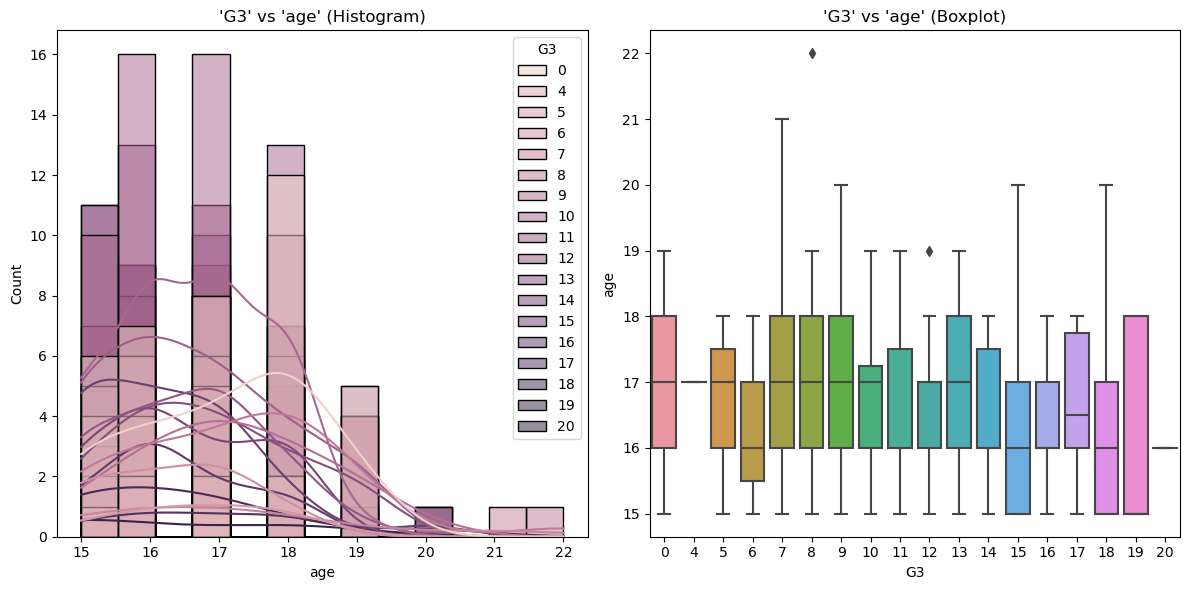

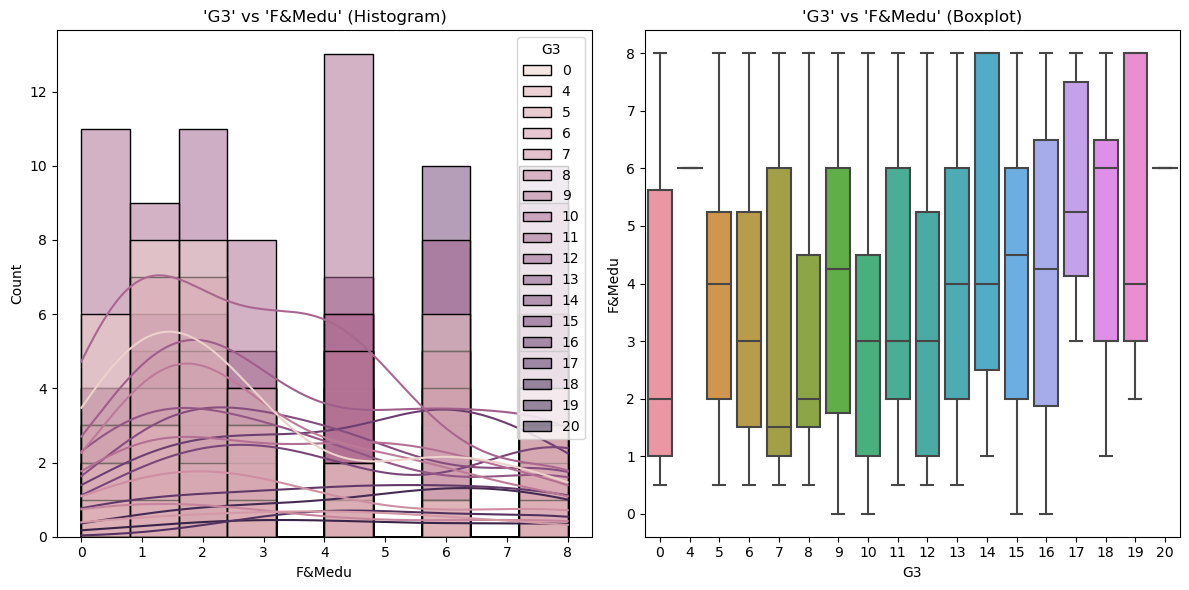

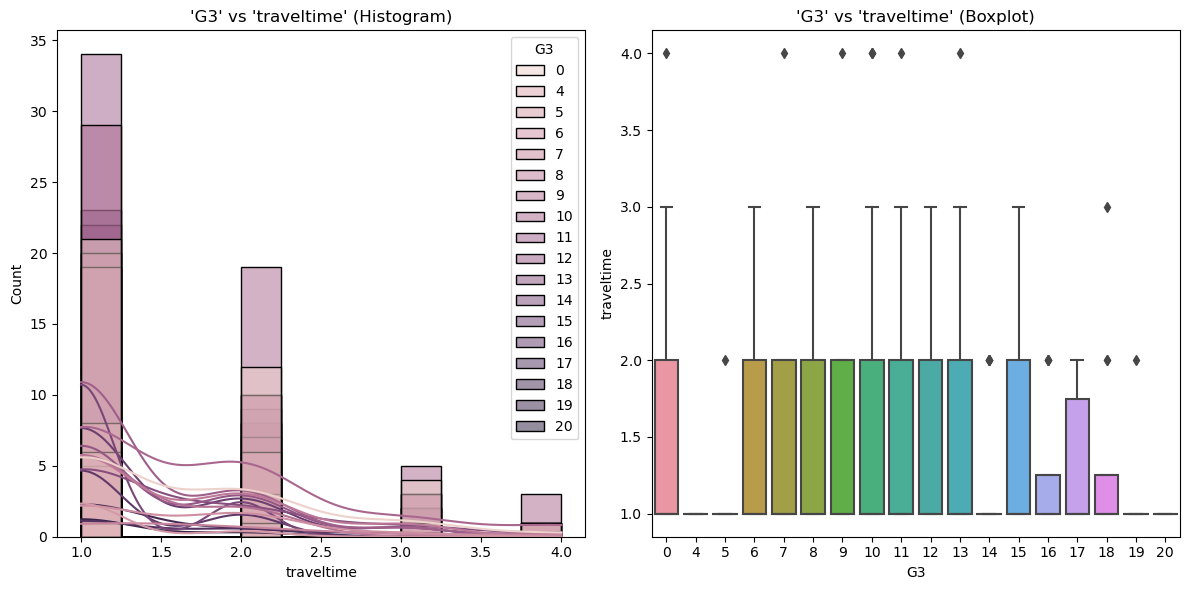

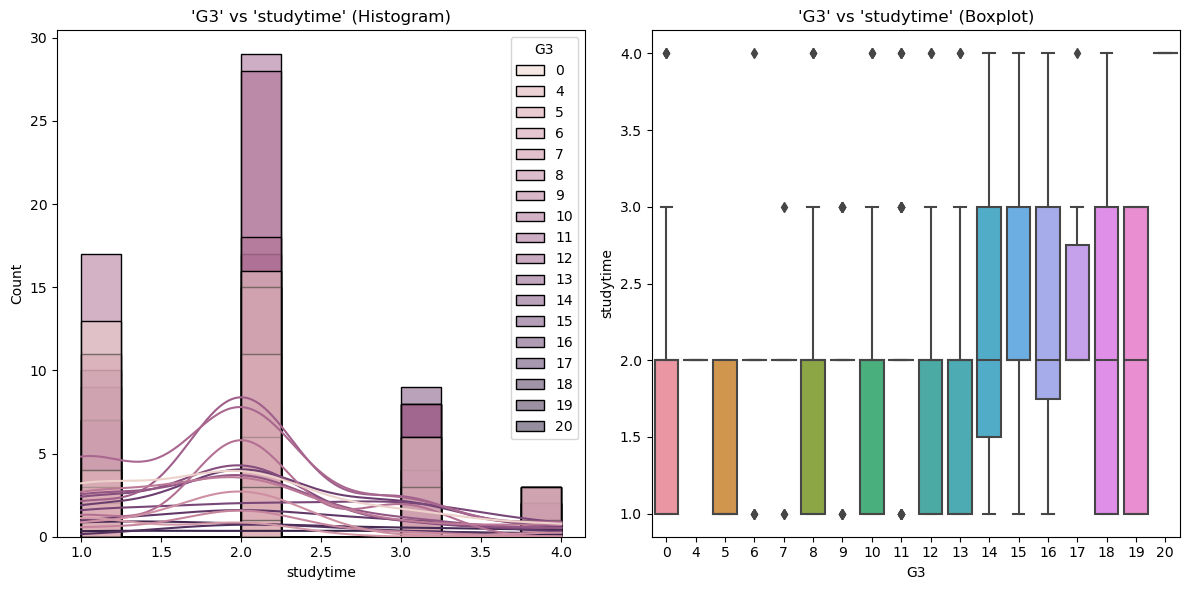

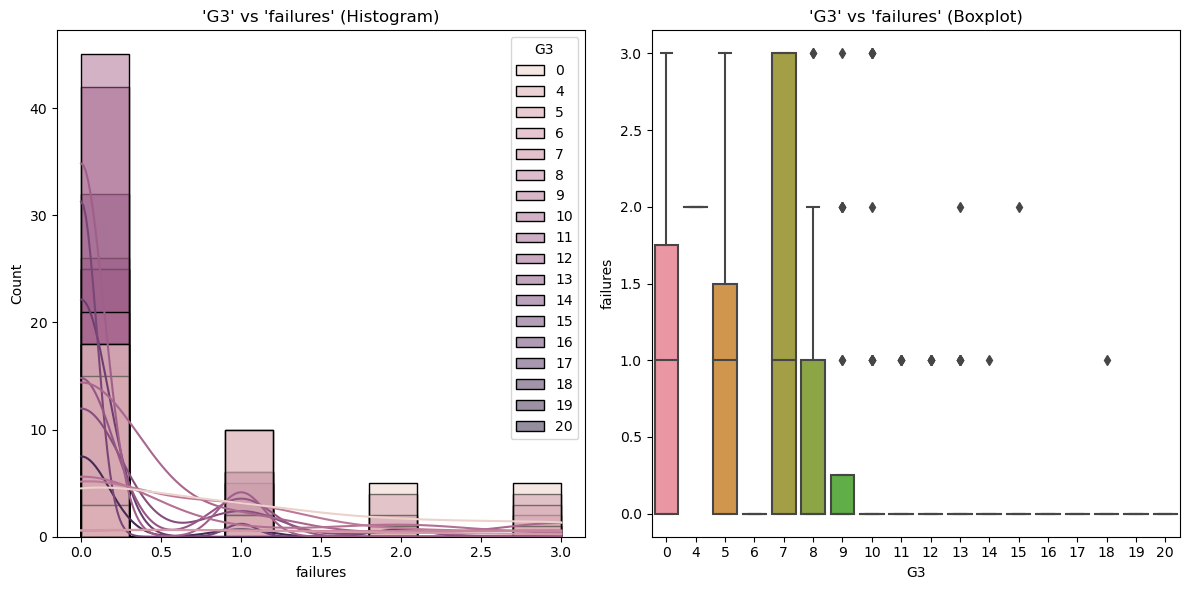

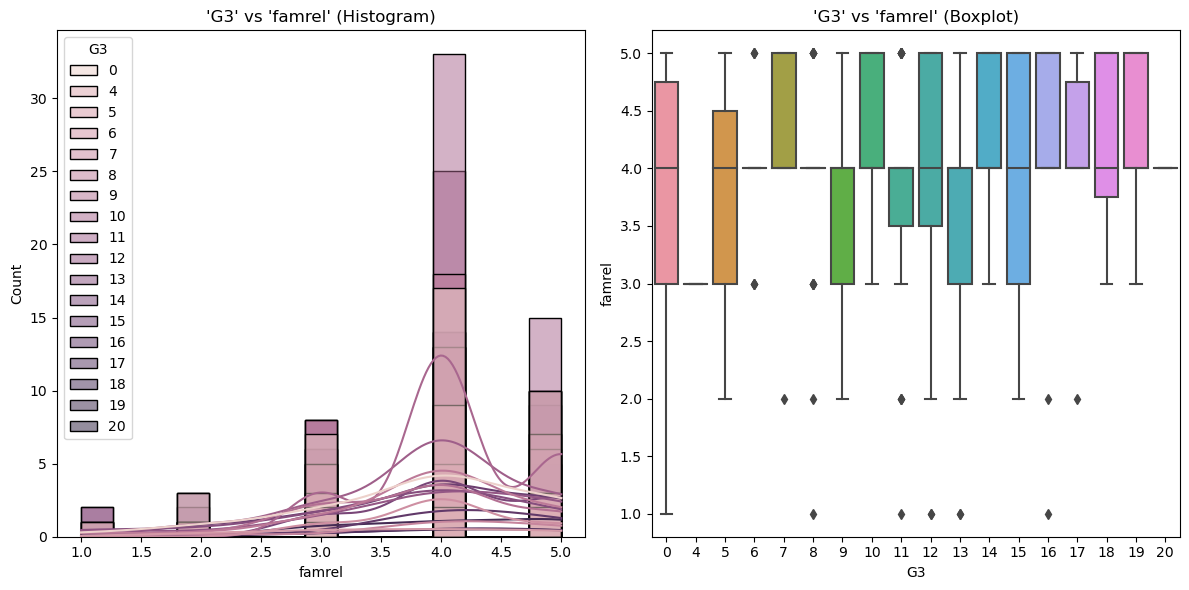

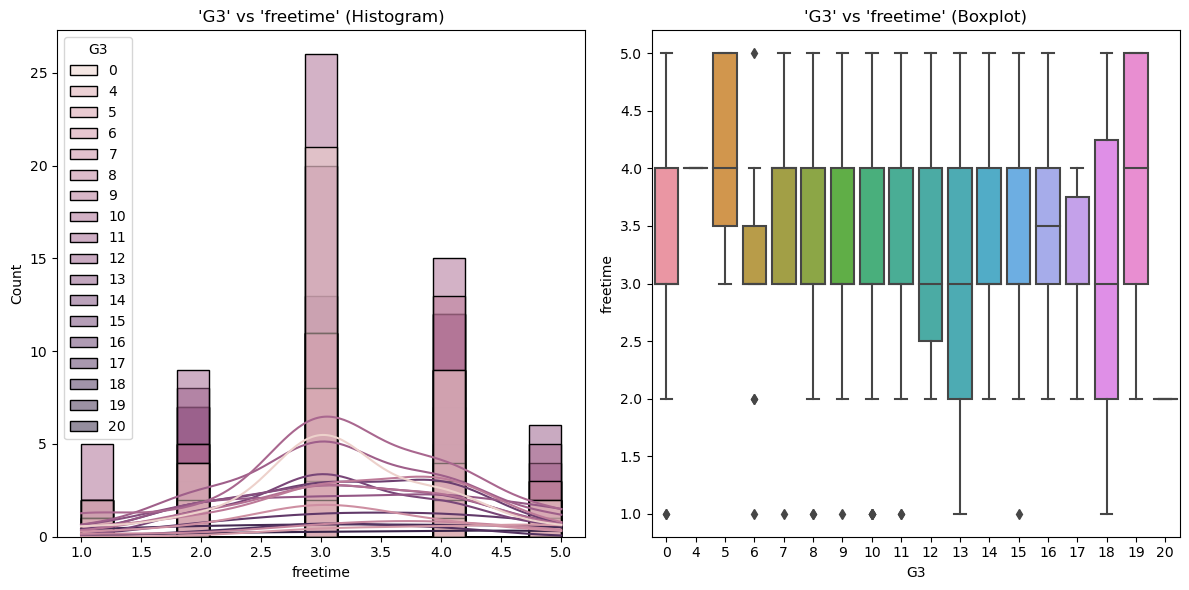

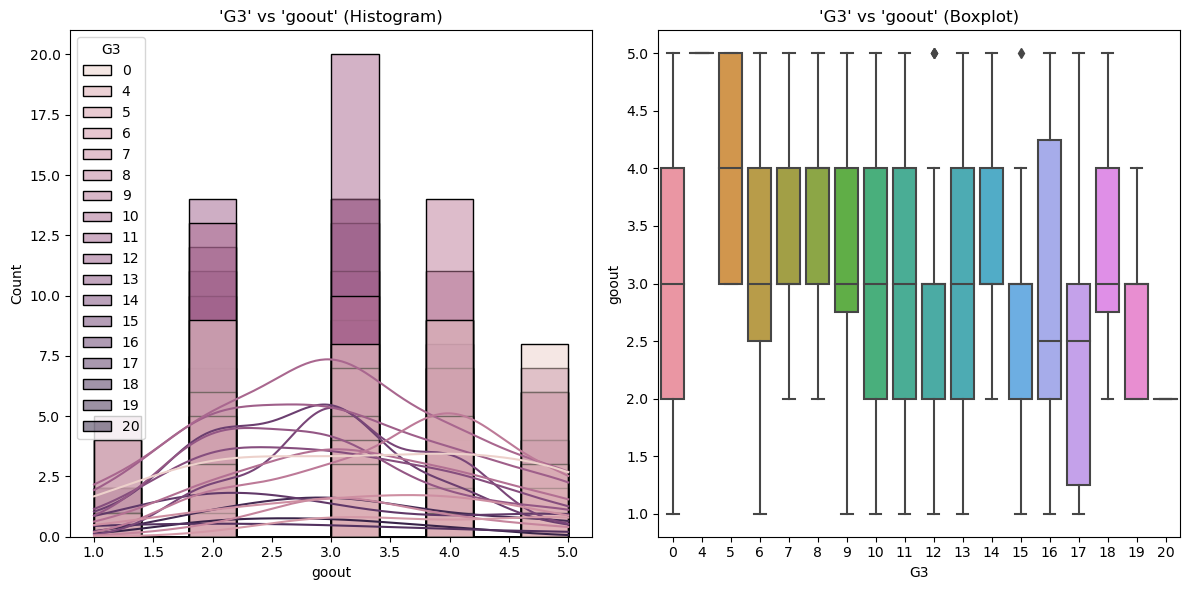

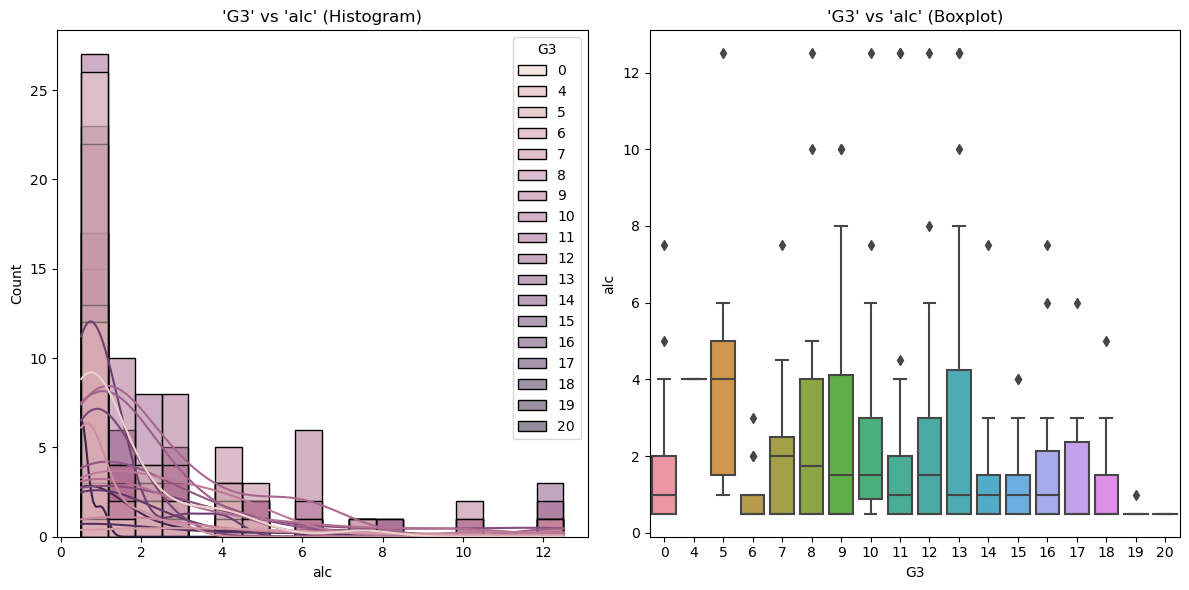

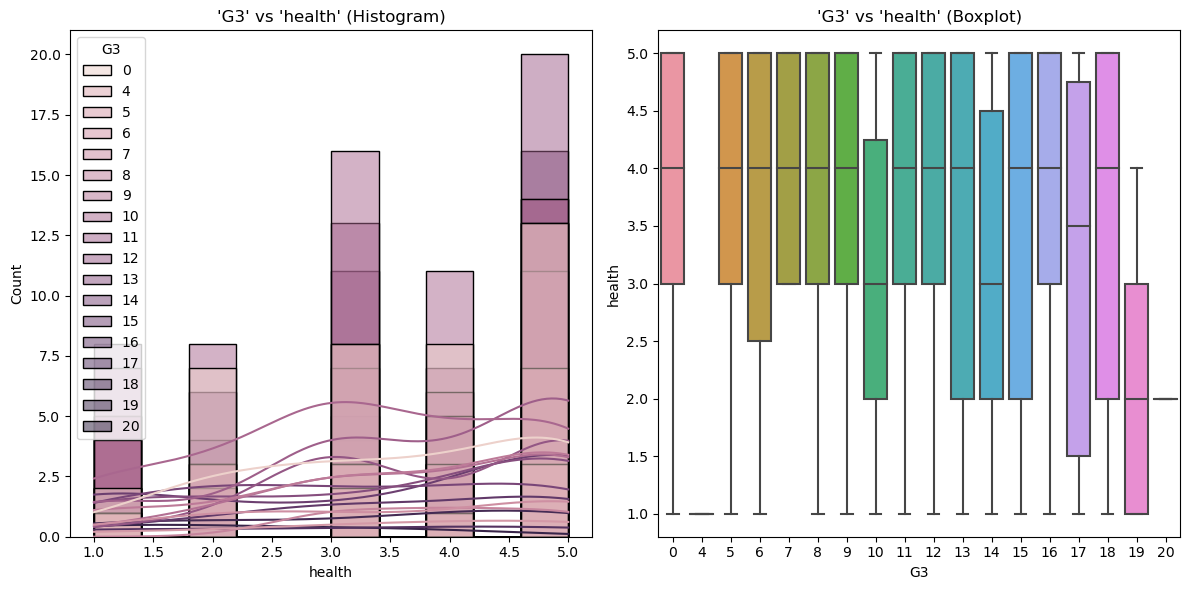

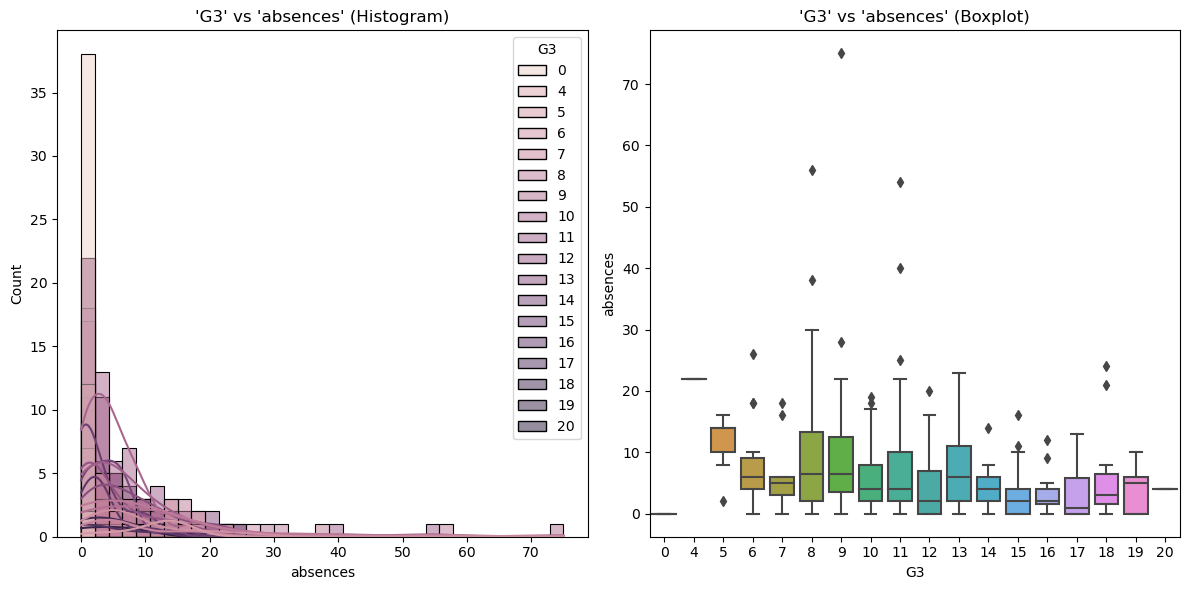

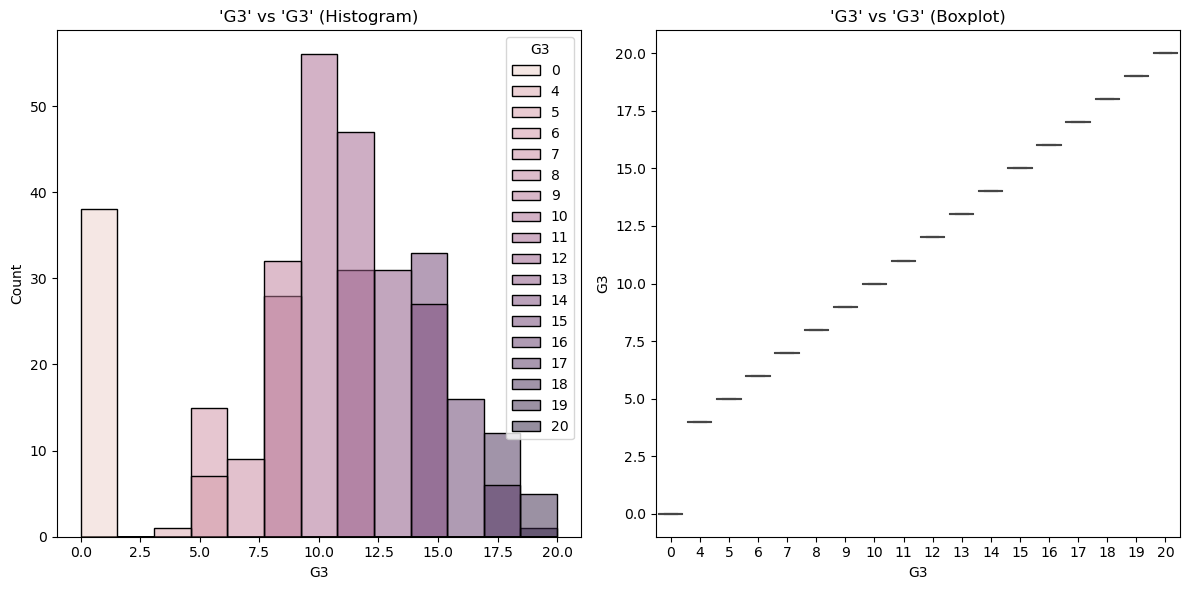

In [58]:

generate_plots_and_tables_by_tagret(data_student, 'G3', num_cols, cat_cols)

In [59]:
# jakie ja mam wnioski z tych wykresów???
# może podziele oceny na grupy ocen i wtedy lepiej to zobaczę

bins = pd.IntervalIndex.from_tuples([(data_student['G3'].min()-1, 10),(10, 14),(14, 18),(18, data_student['G3'].max()+1)])

x = pd.cut(data_student['G3'].to_list(), bins)
x.category = ['ndst', 'dst', 'db', 'cel']

data_student['oceny'] = x

In [65]:
def generate_plots_and_tables_by_tagret(df: pd.DataFrame, target_column: str = "DefFlag",
                                        num_cols: list = [], cat_cols: list = []) -> None:
    """
    Generate plots of the 'target_column' column with other columns in a pandas dataframe.
    If a column is a string or factor, a bar plot with grouping by 'target_column' will be created.
    If a column is continuous, a histogram, boxplot, and scatter plot with grouping by 'target_column' will be created.
    """
    for column in cat_cols:
        print(column + ":")
        
        plt.figure(figsize=(5, 5))
            
        counts = df.groupby([column, target_column], group_keys=True).size()
        print(counts)
        counts_norm = counts.groupby(level=0, group_keys=False).apply(lambda x: 100 * x / x.sum())
        counts_norm = counts_norm.reset_index(name='percent')
        sns.barplot(x=column, y='percent', hue=target_column, data=counts_norm)
        plt.title(f"'oceny' vs '{column}'")
        plt.show()
            
    for column in num_cols:
        
        plt.figure(figsize=(16, 4))
            
        plt.subplot(1, 2, 1)
        sns.histplot(x=column, hue=target_column, data=df, kde=True)
        plt.title(f"'oceny' vs '{column}' (Histogram)")
            
        plt.subplot(1, 2, 2)
        sns.boxplot(x=target_column, y=column, data=df)
        plt.title(f"'oceny' vs '{column}' (Boxplot)")
            
        plt.tight_layout()
        plt.show()

school:
school  oceny   
GP      (-1, 10]    159
        (10, 14]    123
        (14, 18]     62
        (18, 21]      5
MS      (-1, 10]     27
        (10, 14]     13
        (14, 18]      5
        (18, 21]      1
dtype: int64


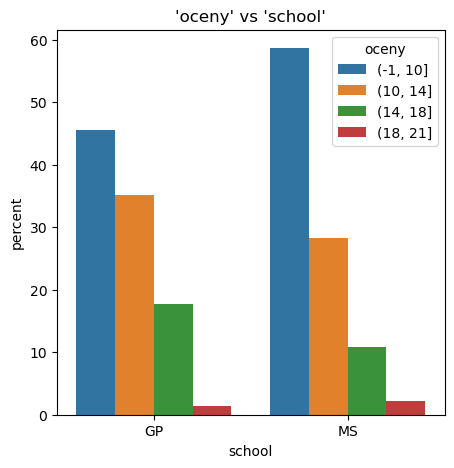

sex:
sex  oceny   
F    (-1, 10]    105
     (10, 14]     71
     (14, 18]     30
     (18, 21]      2
M    (-1, 10]     81
     (10, 14]     65
     (14, 18]     37
     (18, 21]      4
dtype: int64


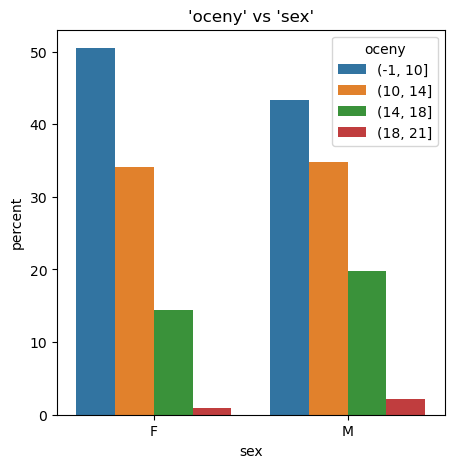

address:
address  oceny   
R        (-1, 10]     50
         (10, 14]     28
         (14, 18]      9
         (18, 21]      1
U        (-1, 10]    136
         (10, 14]    108
         (14, 18]     58
         (18, 21]      5
dtype: int64


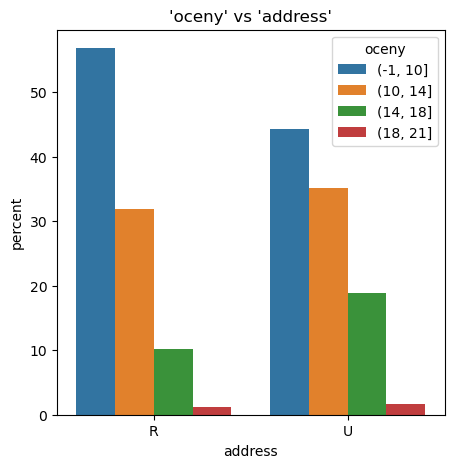

famsize:
famsize  oceny   
GT3      (-1, 10]    136
         (10, 14]     96
         (14, 18]     47
         (18, 21]      2
LE3      (-1, 10]     50
         (10, 14]     40
         (14, 18]     20
         (18, 21]      4
dtype: int64


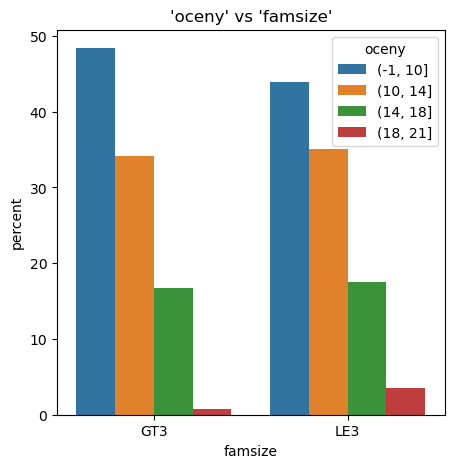

Pstatus:
Pstatus  oceny   
A        (-1, 10]     16
         (10, 14]     16
         (14, 18]      7
         (18, 21]      2
T        (-1, 10]    170
         (10, 14]    120
         (14, 18]     60
         (18, 21]      4
dtype: int64


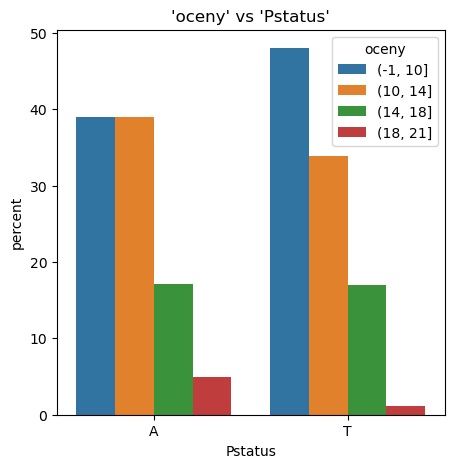

Mjob:
Mjob      oceny   
at_home   (-1, 10]    39
          (10, 14]    14
          (14, 18]     5
          (18, 21]     1
health    (-1, 10]    10
          (10, 14]    13
          (14, 18]    10
          (18, 21]     1
other     (-1, 10]    69
          (10, 14]    56
          (14, 18]    15
          (18, 21]     1
services  (-1, 10]    40
          (10, 14]    37
          (14, 18]    25
          (18, 21]     1
teacher   (-1, 10]    28
          (10, 14]    16
          (14, 18]    12
          (18, 21]     2
dtype: int64


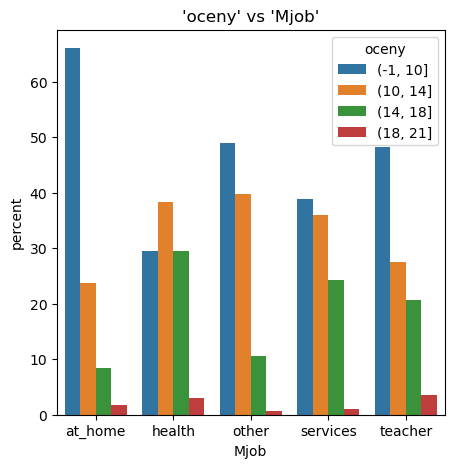

Fjob:
Fjob      oceny   
at_home   (-1, 10]      9
          (10, 14]      7
          (14, 18]      3
          (18, 21]      1
health    (-1, 10]      8
          (10, 14]      6
          (14, 18]      4
          (18, 21]      0
other     (-1, 10]    107
          (10, 14]     77
          (14, 18]     30
          (18, 21]      3
services  (-1, 10]     53
          (10, 14]     38
          (14, 18]     19
          (18, 21]      1
teacher   (-1, 10]      9
          (10, 14]      8
          (14, 18]     11
          (18, 21]      1
dtype: int64


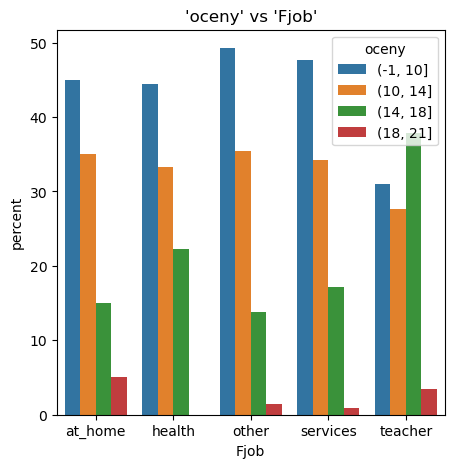

reason:
reason      oceny   
course      (-1, 10]    73
            (10, 14]    47
            (14, 18]    23
            (18, 21]     2
home        (-1, 10]    53
            (10, 14]    37
            (14, 18]    18
            (18, 21]     1
other       (-1, 10]    16
            (10, 14]    13
            (14, 18]     6
            (18, 21]     1
reputation  (-1, 10]    44
            (10, 14]    39
            (14, 18]    20
            (18, 21]     2
dtype: int64


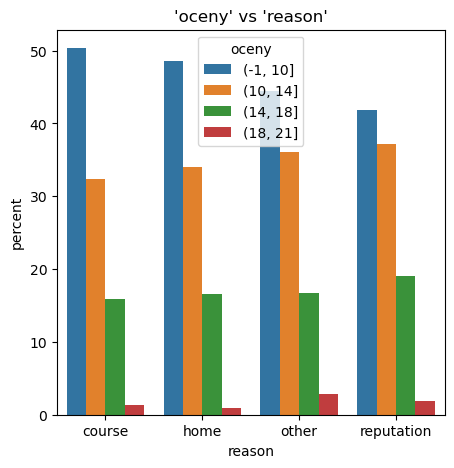

guardian:
guardian  oceny   
father    (-1, 10]     41
          (10, 14]     33
          (14, 18]     16
          (18, 21]      0
mother    (-1, 10]    126
          (10, 14]     93
          (14, 18]     48
          (18, 21]      6
other     (-1, 10]     19
          (10, 14]     10
          (14, 18]      3
          (18, 21]      0
dtype: int64


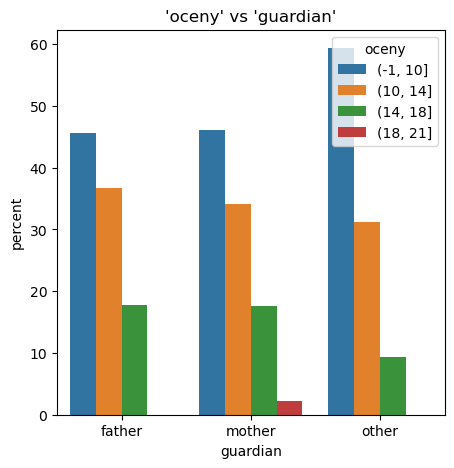

schoolsup:
schoolsup  oceny   
no         (-1, 10]    153
           (10, 14]    120
           (14, 18]     65
           (18, 21]      6
yes        (-1, 10]     33
           (10, 14]     16
           (14, 18]      2
           (18, 21]      0
dtype: int64


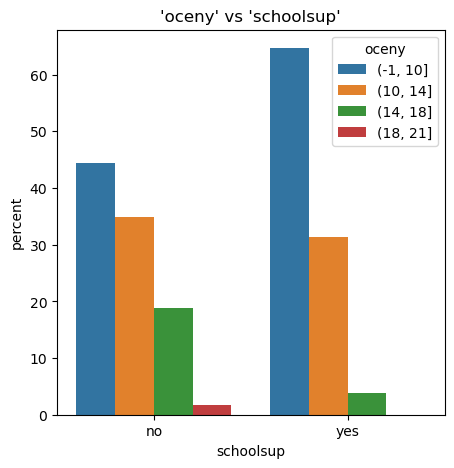

famsup:
famsup  oceny   
no      (-1, 10]     69
        (10, 14]     53
        (14, 18]     27
        (18, 21]      4
yes     (-1, 10]    117
        (10, 14]     83
        (14, 18]     40
        (18, 21]      2
dtype: int64


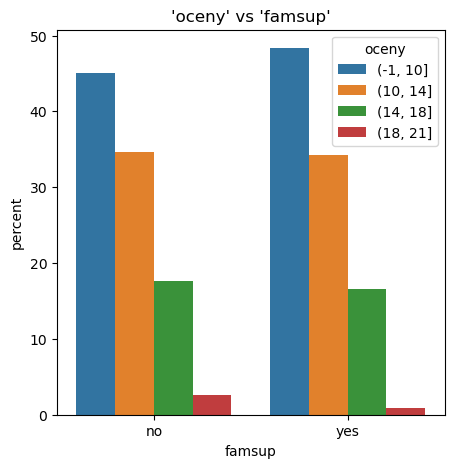

paid:
paid  oceny   
no    (-1, 10]    105
      (10, 14]     68
      (14, 18]     37
      (18, 21]      4
yes   (-1, 10]     81
      (10, 14]     68
      (14, 18]     30
      (18, 21]      2
dtype: int64


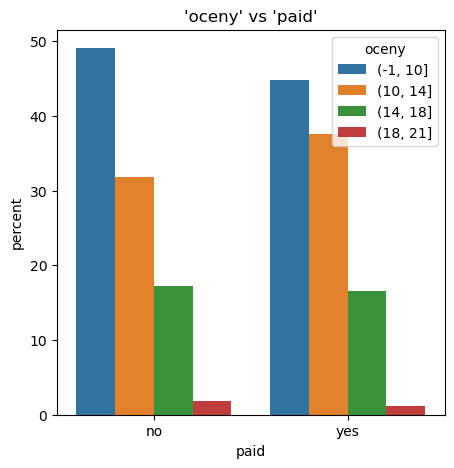

activities:
activities  oceny   
no          (-1, 10]    92
            (10, 14]    68
            (14, 18]    30
            (18, 21]     4
yes         (-1, 10]    94
            (10, 14]    68
            (14, 18]    37
            (18, 21]     2
dtype: int64


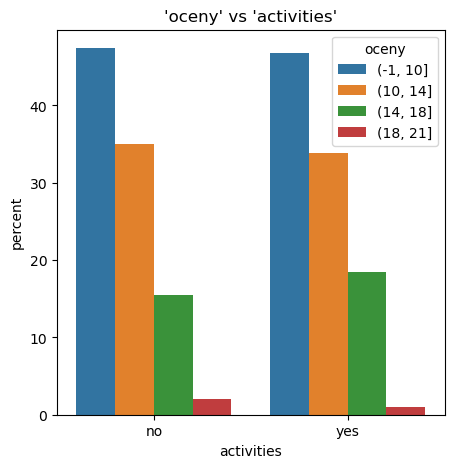

nursery:
nursery  oceny   
no       (-1, 10]     36
         (10, 14]     33
         (14, 18]     12
         (18, 21]      0
yes      (-1, 10]    150
         (10, 14]    103
         (14, 18]     55
         (18, 21]      6
dtype: int64


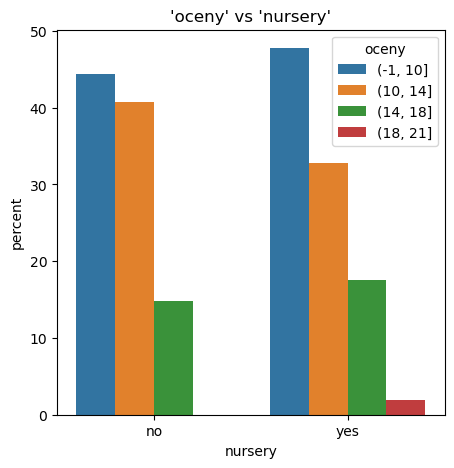

romantic:
romantic  oceny   
no        (-1, 10]    123
          (10, 14]     85
          (14, 18]     49
          (18, 21]      6
yes       (-1, 10]     63
          (10, 14]     51
          (14, 18]     18
          (18, 21]      0
dtype: int64


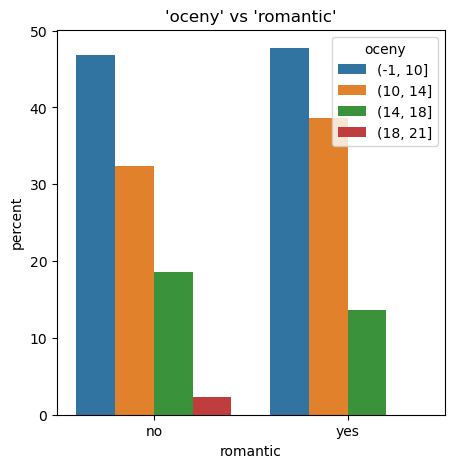

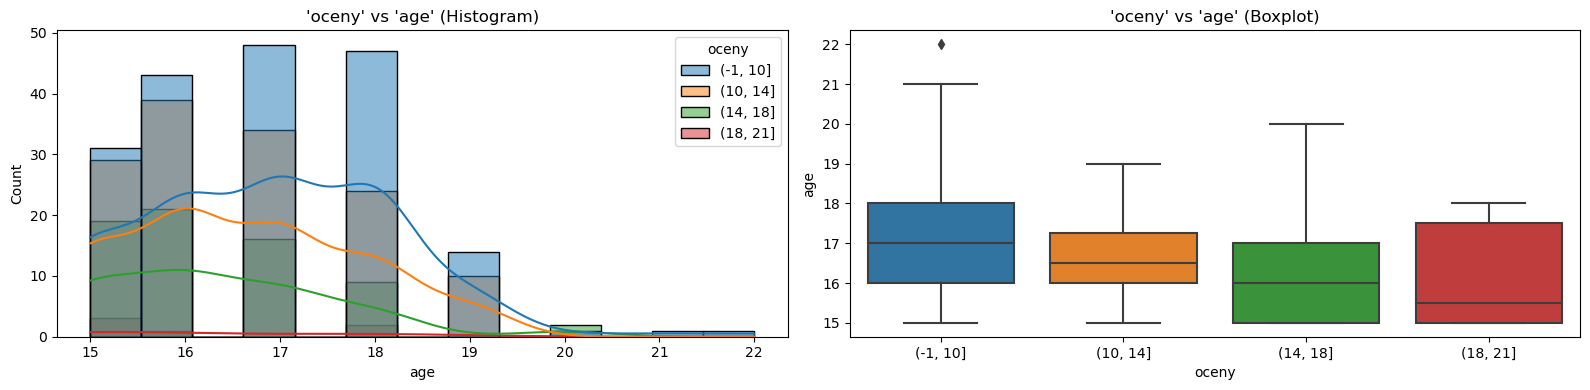

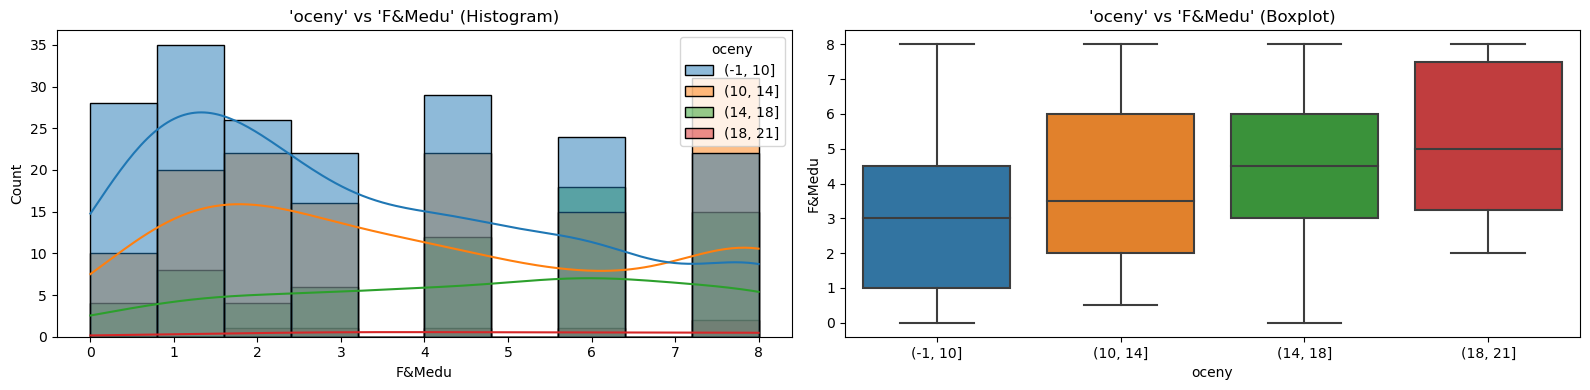

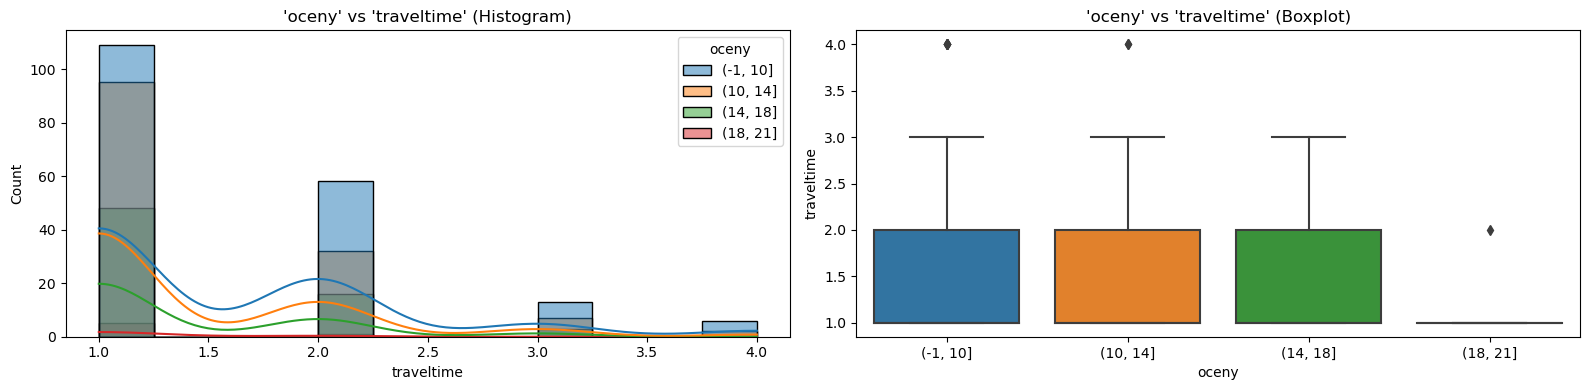

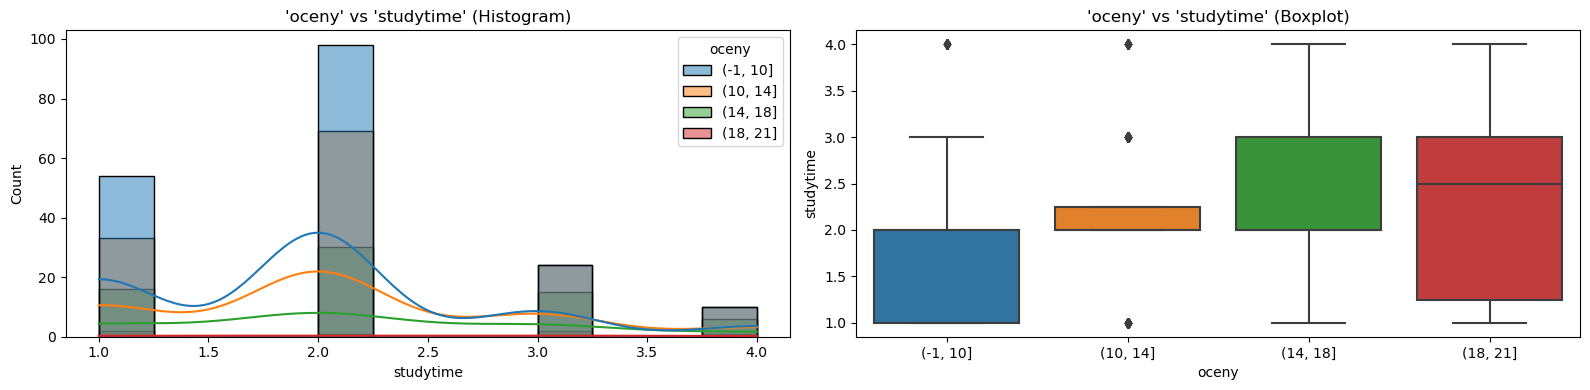

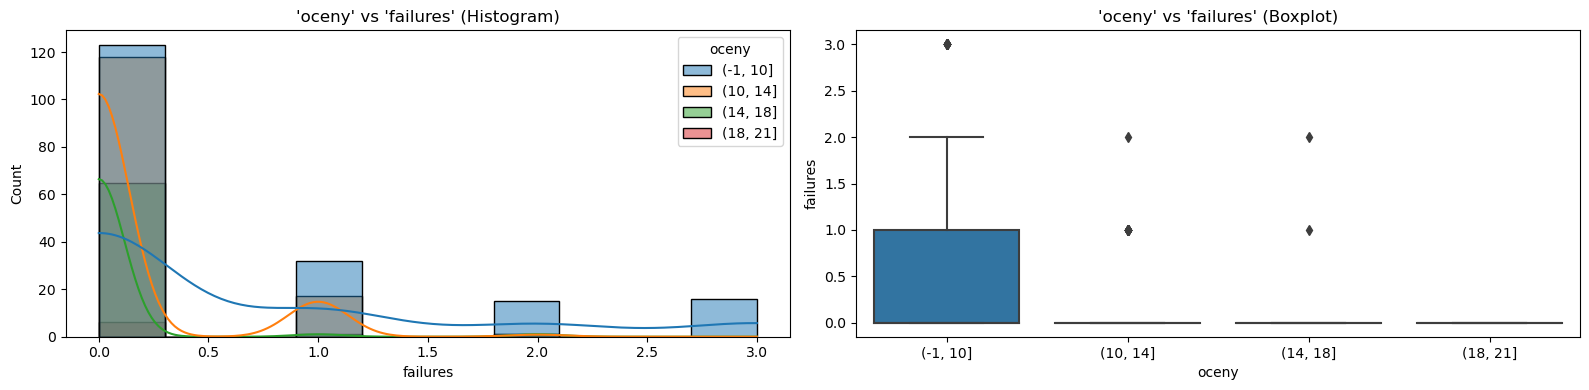

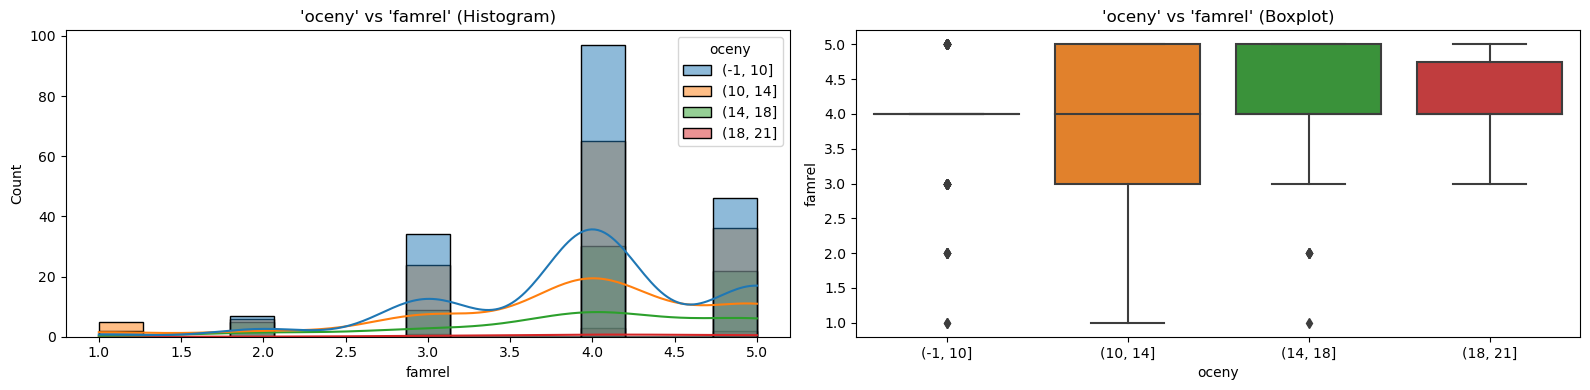

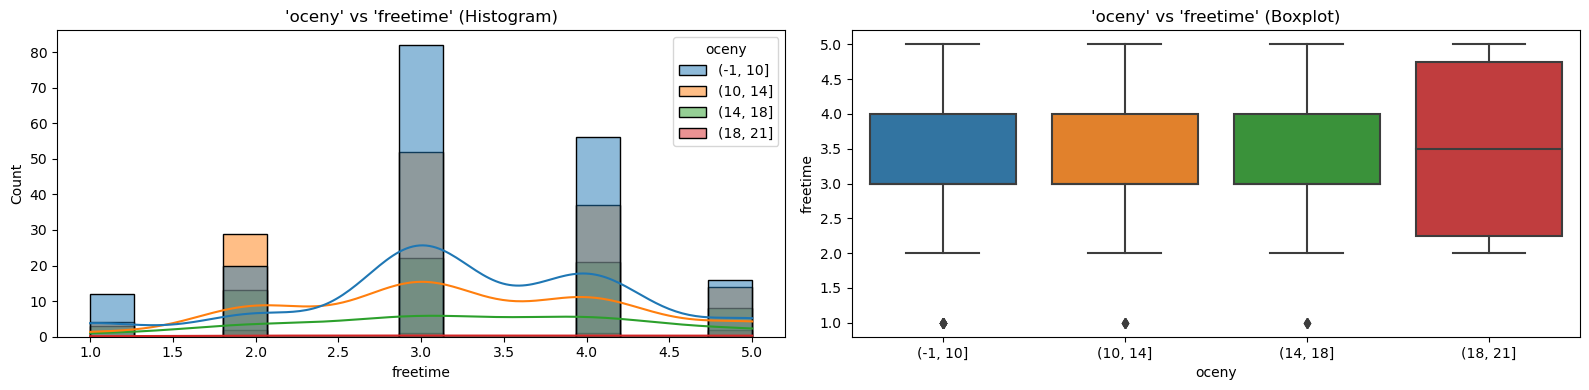

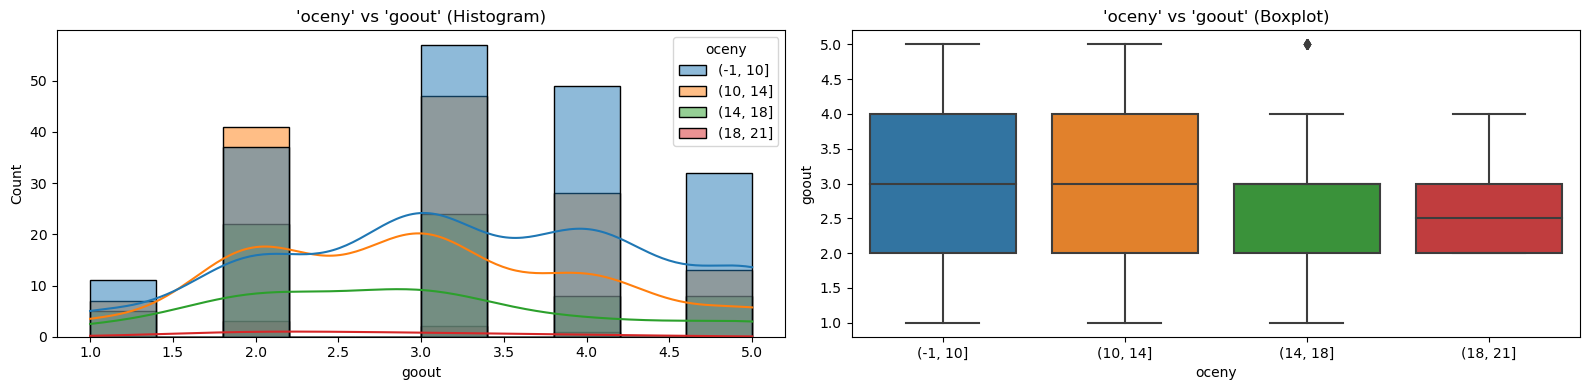

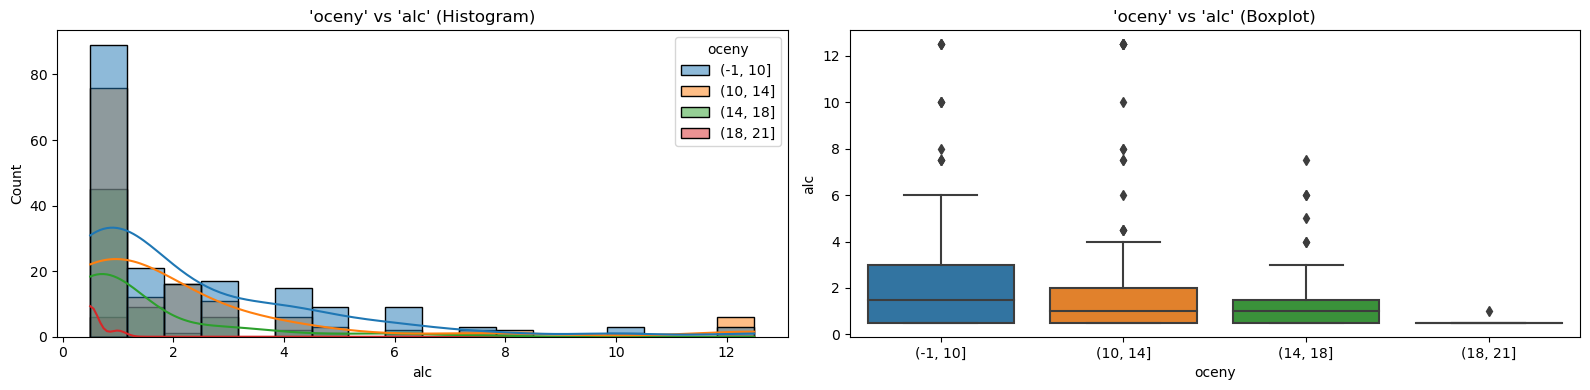

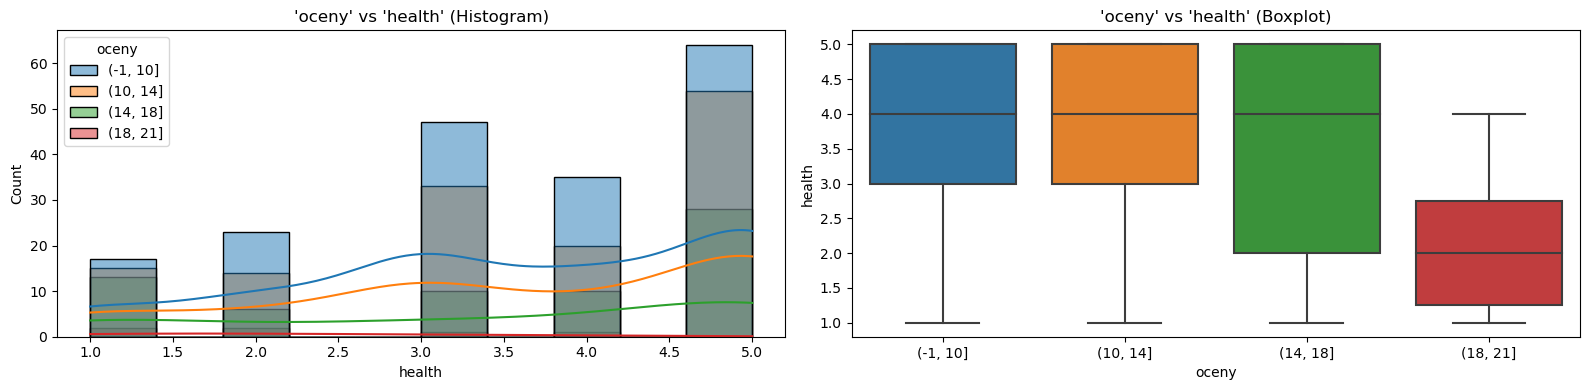

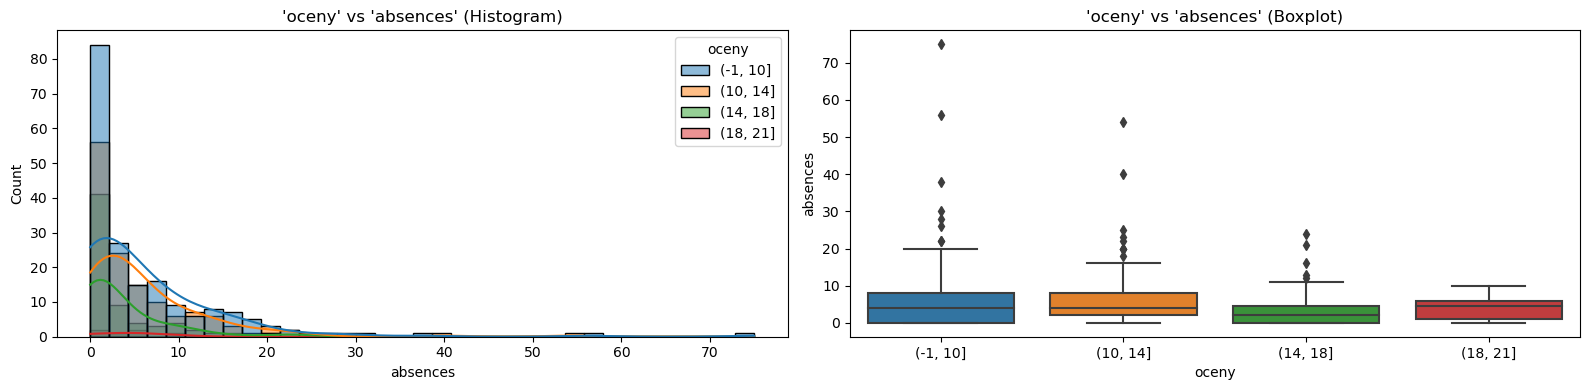

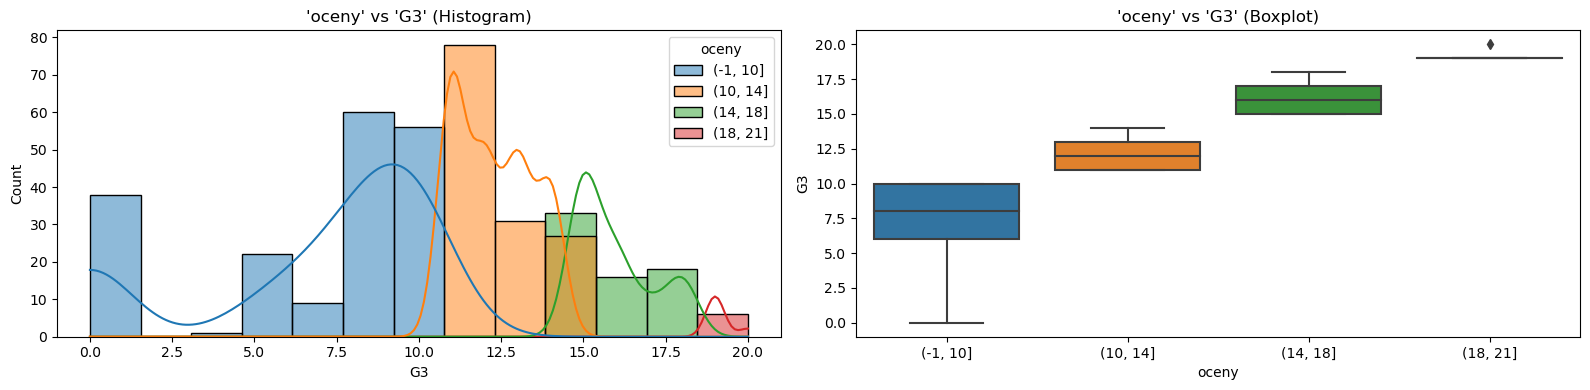

In [66]:
generate_plots_and_tables_by_tagret(data_student, 'oceny', num_cols, cat_cols)

Te wykresy sa czytelniejsze - wnioski - tylko usunmy outliery - czy da się zrobić żby liczyół procentowy udział
szkoła - oceny - MS - ma więcej słabych ponad 60% niezaliczone, ale ma tez procentowy udział celujących ocen
płeć - więcej słabych w grupie dziewcząt
miejsce zamieszkania - więcej slabych w zamieszkaniu wiejskim - dojazd, dostęp do dodatkowych?
wielkość rodziny - słabiej ywpadaja duże rodzinr
status rodziny - rodzice mieszkający osobno lepiej wypadają
praca matki - najgorzej gdy jest w domu, może się to wiązac z wykształceniem
praca ojca - najlepiej gdy jest w domu
powód wybrania szkoły - dobrze gdy ze względu na reoutacje - świadomi uczniowie
opiekun - najgorzej gdy jest inny niż matka i ojciec
wparcie szkoły - lepiej wypadaja uczniowie bez wsparcia - może dlatego że szkoła prowadzi zajęcia wspomagające dla słabszych uczniów
wsparcie rodziny - nic
płatne zajęcia - dla słabszych dają
aktywności - nic
nursery, romantic - nic
age - starsi wiekowo raczej słabiej, pradopodobnie ze względu na powtarzzanie klas i ogólnie słabszość
wykształcenie rodziców - im wyższe tym lepsze oceny i miej ocen niezaliczających
failures - liczba niepowozeń, osoby wcześńiej niezdające w klasach teraz tez niezaliczają
relacje rodzinne - ?
alcohol - w grupie ocen najlepszych nie ma alco za dużo, ??
zdrowie - osoby z lepszymi ocenami - słabiej oceniają zdrowie, 


# 7. Normalizacja zmiennych

In [67]:
# Tworzenie obiektu skaler
scaler = MinMaxScaler()

# Dopasowanie skalera do danych i wykonanie transformacji
data_student_normalized1 = scaler.fit_transform(data_student[num_cols])
print(data_student_normalized1)

[[0.42857143 1.         0.33333333 ... 0.5        0.08       0.3       ]
 [0.28571429 0.0625     0.         ... 0.5        0.05333333 0.3       ]
 [0.         0.0625     0.         ... 0.5        0.13333333 0.5       ]
 ...
 [0.85714286 0.0625     0.         ... 0.5        0.04       0.35      ]
 [0.42857143 0.375      0.66666667 ... 1.         0.         0.5       ]
 [0.57142857 0.0625     0.         ... 1.         0.06666667 0.45      ]]


# 8. Kodowanie zmiennych kategorycznych

In [68]:
# inicjalizacja OneHotEncoder
encoder = OneHotEncoder()

# dopasowanie i transformacja danych
transformed_data = encoder.fit_transform(data_student[cat_cols])

# wyświetlenie wyników
print(transformed_data.toarray())

[[1. 0. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 [1. 0. 1. ... 1. 1. 0.]
 ...
 [0. 1. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 1. 1. 0.]]


In [74]:
#pozmieniam zmienne objekt na category - jednak nie będę zmieniać
data_student.school = data_student.school.astype('category')
data_student.sex = data_student.sex.astype('category')
data_student.address = data_student.address.astype('category')
data_student.famsize = data_student.famsize.astype('category')
data_student.Pstatus = data_student.Pstatus.astype('category')
data_student.Mjob = data_student.Mjob.astype('category')
data_student.Fjob = data_student.Fjob.astype('category')
data_student.reason = data_student.reason.astype('category')
data_student.guardian = data_student.guardian.astype('category')
data_student.schoolsup = data_student.schoolsup.astype('category')
data_student.famsup = data_student.famsup.astype('category')
data_student.paid = data_student.paid.astype('category')
data_student.activities = data_student.activities.astype('category')
data_student.nursery = data_student.nursery.astype('category')
data_student.romantic = data_student.romantic.astype('category')

# 9. Tworzenie modeli


In [75]:
#wybór indeksów do zbioru treningowego i testowego (funkcja train_test_split)
X, y = data_student.drop(columns=['G3'], axis=1), data_student['G3']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

cat_ix = X.select_dtypes(include=['object', 'bool']).columns
num_ix = X.select_dtypes(include=['int64', 'float64']).columns


In [76]:
#jak tu sprawdzic podział na testowy i treningowy????

In [77]:
key = ['LogisticRegression','KNeighborsClassifier','SVC','DecisionTreeClassifier','RandomForestClassifier','GradientBoostingClassifier','AdaBoostClassifier']
value = [LogisticRegression(), KNeighborsClassifier(n_neighbors = 2, weights ='uniform'), SVC(kernel="rbf",random_state=15), DecisionTreeClassifier(random_state=10), RandomForestClassifier(n_estimators=60, random_state=0), GradientBoostingClassifier(random_state=20), AdaBoostClassifier()]
models = dict(zip(key,value))
models

{'LogisticRegression': LogisticRegression(),
 'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=2),
 'SVC': SVC(random_state=15),
 'DecisionTreeClassifier': DecisionTreeClassifier(random_state=10),
 'RandomForestClassifier': RandomForestClassifier(n_estimators=60, random_state=0),
 'GradientBoostingClassifier': GradientBoostingClassifier(random_state=20),
 'AdaBoostClassifier': AdaBoostClassifier()}

In [78]:
cat_ix = X.select_dtypes(include=['object', 'category', 'bool']).columns
num_ix = X.select_dtypes(include=['int64', 'float64']).columns

In [79]:
X, y = data_student.drop(columns=['G3'], axis=1), data_student['G3']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [73]:
dokladnosc =[]
transformation_steps = [
    ('c', OneHotEncoder(handle_unknown='ignore'), cat_ix),
    ('n', MinMaxScaler(), num_ix)
]
for name, algorytm in models.items():
    model=algorytm
    model.fit(X_train,y_train)
    predict = model.predict(X_test)
    acc = accuracy_score(y_test, predict)
    cm = confusion_matrix(y_test, predict)
    dokladnosc.append(acc)
    plot_confusion_matrix(model, X_test, y_test, cmap = 'RdPu')
    print(f'DOKŁADNOŚĆ MODELU {name} WYNOSI: ', round(acc,4))
    plt.show()

ValueError: could not convert string to float: 'GP'

In [80]:
transformation_steps = [
    ('c', OneHotEncoder(handle_unknown='ignore'), cat_ix),
    ('n', MinMaxScaler(), num_ix)
]
ct = ColumnTransformer(transformation_steps)
pipeline = Pipeline(
    steps=[
        ('transform', ct),
        ('smote', SMOTE()),
        ('model', GradientBoostingClassifier())
    ])
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)
param_grid = {
    "model__n_estimators": [50, 100] 
}
grid_search = GridSearchCV(
    estimator=pipeline, param_grid=param_grid, cv=cv, scoring="f1_macro"
)
grid_search.fit(X_train, y_train)

C:\ProgramData\anaconda3\envs\ania\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\ProgramData\anaconda3\envs\ania\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\ProgramData\anaconda3\envs\ania\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


ValueError: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\envs\ania\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\anaconda3\envs\ania\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\anaconda3\envs\ania\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\ProgramData\anaconda3\envs\ania\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\ProgramData\anaconda3\envs\ania\lib\site-packages\imblearn\pipeline.py", line 422, in _fit_resample_one
    X_res, y_res = sampler.fit_resample(X, y, **fit_params)
  File "C:\ProgramData\anaconda3\envs\ania\lib\site-packages\imblearn\base.py", line 203, in fit_resample
    return super().fit_resample(X, y)
  File "C:\ProgramData\anaconda3\envs\ania\lib\site-packages\imblearn\base.py", line 88, in fit_resample
    output = self._fit_resample(X, y)
  File "C:\ProgramData\anaconda3\envs\ania\lib\site-packages\imblearn\over_sampling\_smote\base.py", line 355, in _fit_resample
    nns = self.nn_k_.kneighbors(X_class, return_distance=False)[:, 1:]
  File "C:\ProgramData\anaconda3\envs\ania\lib\site-packages\sklearn\neighbors\_base.py", line 810, in kneighbors
    raise ValueError(
ValueError: Expected n_neighbors <= n_samples,  but n_samples = 5, n_neighbors = 6

--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\envs\ania\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\anaconda3\envs\ania\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\anaconda3\envs\ania\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\ProgramData\anaconda3\envs\ania\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\ProgramData\anaconda3\envs\ania\lib\site-packages\imblearn\pipeline.py", line 422, in _fit_resample_one
    X_res, y_res = sampler.fit_resample(X, y, **fit_params)
  File "C:\ProgramData\anaconda3\envs\ania\lib\site-packages\imblearn\base.py", line 203, in fit_resample
    return super().fit_resample(X, y)
  File "C:\ProgramData\anaconda3\envs\ania\lib\site-packages\imblearn\base.py", line 88, in fit_resample
    output = self._fit_resample(X, y)
  File "C:\ProgramData\anaconda3\envs\ania\lib\site-packages\imblearn\over_sampling\_smote\base.py", line 355, in _fit_resample
    nns = self.nn_k_.kneighbors(X_class, return_distance=False)[:, 1:]
  File "C:\ProgramData\anaconda3\envs\ania\lib\site-packages\sklearn\neighbors\_base.py", line 810, in kneighbors
    raise ValueError(
ValueError: Expected n_neighbors <= n_samples,  but n_samples = 4, n_neighbors = 6


In [ ]:
best_estimator = grid_search.best_estimator_

y_pred = best_estimator.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print('ROC AUC score:', roc_auc_score(y_test, y_pred))